In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import WEIRDOFunctions
%matplotlib inline

# Bring in the Observed (UNSODA) data

The database was downloaded from:
https://www.ars.usda.gov/research/software/download/?modeCode=20-36-05-00&softwareid=106

Necessary data was exported from access data base to excell sheets and imported into Pandas

In [2]:
CondData = pd.read_excel('.\Data\lab_drying_h-k.xlsx') # in cm/d
ThetaData = pd.read_excel('.\Data\lab_drying_h-t.xlsx') # in cm3/cm3
PropertiesData = pd.read_excel('.\Data\SoilProperties.xlsx')
SizeDistribution = pd.read_excel('.\Data\ParticleSizeDistribution.xlsx')
PropertiesData.set_index('code',inplace=True)
SizeDistribution.set_index('code',inplace=True)

### Join h, k and t data into a single data frame and have a quick look

In [3]:
MergedData = pd.merge(left=ThetaData, right=CondData,on=['code','preshead'])

In [4]:
Data = MergedData.dropna()

In [5]:
Data.set_index('code',inplace=True,drop=False)

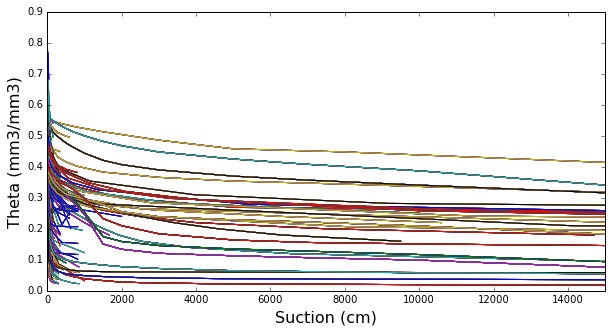

In [6]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],Data.ix[soil,'theta'])
plt.xlim(0,15000)
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)

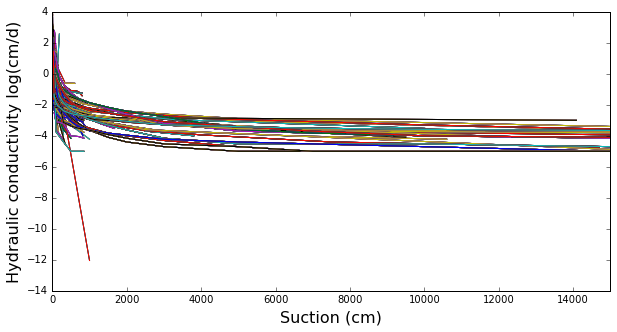

In [7]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],np.log10(Data.ix[soil,'conductivity']))
plt.xlim(0,15000)
plt.ylabel('Hydraulic conductivity log(cm/d)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)


### Quite alot of soils have insufficient range in their k and theta measurements to be useful.  
### Filter out anything that has a narrow range of measurements

In [8]:
#This cell throws a copy slice error and takes a long time to run, but it still does what is intended.
Data.ix[:,'FullSet'] = 'false'
for soil in Data.index:
    if Data.ix[soil,'preshead'].max() >= 15000 and Data.ix[soil,'preshead'].min() <= 100:
        Data.ix[soil,'FullSet'] = 'true'

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
SetFilter = Data.ix[:,'FullSet'] == 'true'

In [10]:
FullData = Data.ix[SetFilter,:].copy()

### Convert conductivity data to mm/h and potentials to mmH2O

In [11]:
condcmd = FullData.ix[:,'conductivity']
prescm = FullData.ix[:,'preshead']
Ksatcmd = PropertiesData.ix[:,'k_sat']
FullData.ix[:,'conductivity'] = condcmd*10/24
FullData.ix[:,'preshead'] = prescm * 10
PropertiesData.ix[:,'k_sat'] = Ksatcmd *10/24

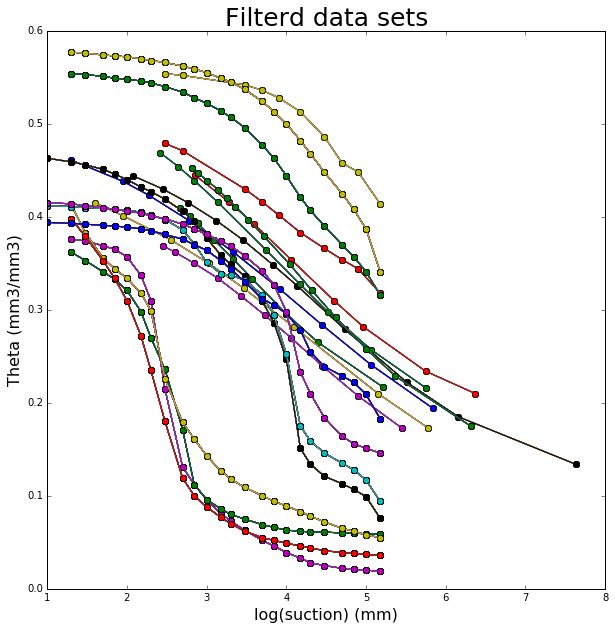

In [12]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(np.log10(FullData.ix[soil,'preshead']),FullData.ix[soil,'theta'],'o-')
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('log(suction) (mm)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)


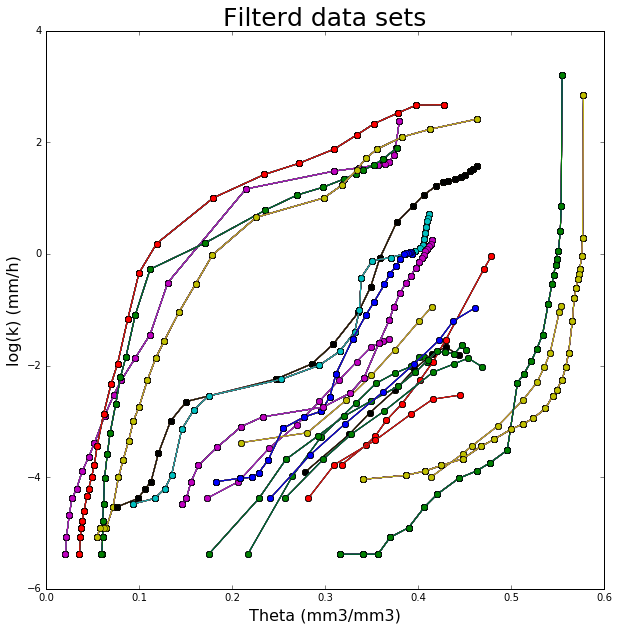

In [13]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(FullData.ix[soil,'theta'],np.log10(FullData.ix[soil,'conductivity']),'o-')
plt.xlabel('Theta (mm3/mm3)',fontsize=16)
plt.ylabel('log(k) (mm/h)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)

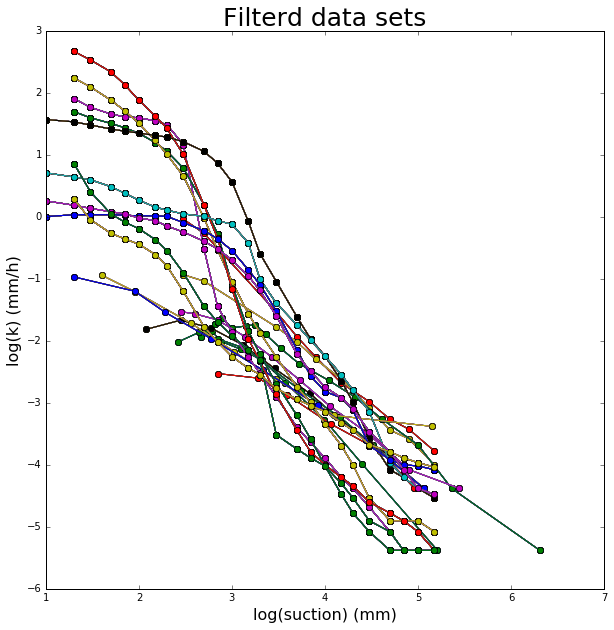

In [14]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(np.log10(FullData.ix[soil,'preshead']),np.log10(FullData.ix[soil,'conductivity']),'o-')
plt.xlabel('log(suction) (mm)',fontsize=16)
plt.ylabel('log(k) (mm/h)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)
#plt.ylim(0,0.001)

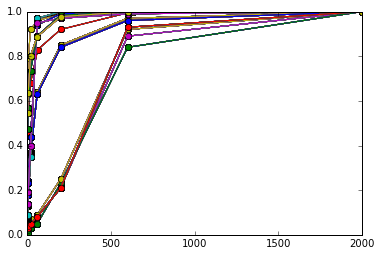

In [15]:
for soil in FullData.index:
    plt.plot(SizeDistribution.ix[soil,'particle_size'],SizeDistribution.ix[soil,'particle_fraction'],'o-')

### Work up texture data 

In [16]:
Texture = pd.DataFrame(index = SizeDistribution.dropna().index.drop_duplicates(),columns = ['Sand','Silt','Clay'])

ClayFilter = SizeDistribution.particle_size <= 2
SiltFilter = (SizeDistribution.particle_size > 2) & (SizeDistribution.particle_size <= 60)
SandFilter = SizeDistribution.particle_size > 60
for soil in Texture.index:
    try:
        Texture.ix[soil,'Clay'] = SizeDistribution.ix[ClayFilter].ix[soil,'particle_fraction'].max()
        Texture.ix[soil,'Silt'] = SizeDistribution.ix[SiltFilter].ix[soil,'particle_fraction'].max() - Texture.ix[soil,'Clay']
        Texture.ix[soil,'Sand'] = 1.0 - Texture.ix[soil,'Clay'] - Texture.ix[soil,'Silt']
    except:
        print(str(soil)+ ' has no texture data')

1290 has no texture data
1330 has no texture data
1331 has no texture data
1390 has no texture data
1391 has no texture data
1392 has no texture data
1410 has no texture data
2220 has no texture data
2221 has no texture data
2240 has no texture data
2241 has no texture data
2242 has no texture data
2243 has no texture data
2250 has no texture data
2251 has no texture data
2252 has no texture data
2253 has no texture data
2260 has no texture data
2261 has no texture data
2262 has no texture data
2270 has no texture data
2271 has no texture data
2272 has no texture data
2273 has no texture data
2280 has no texture data
2281 has no texture data
2282 has no texture data
2283 has no texture data
2290 has no texture data
2291 has no texture data
2292 has no texture data
2293 has no texture data
2300 has no texture data
2301 has no texture data
2302 has no texture data
2303 has no texture data
2304 has no texture data
2305 has no texture data
2306 has no texture data
2307 has no texture data


# Now lets set up equations for modelling moisture release and conductivity curves

### Set up arrays with the pore boundary settings

In [17]:
PoreBounds = [ 3000, 1194, 475, 189, 75, 30, 8.6, 2.47, 0.707, 0.202, 0.0005 ]

BoundPSI =  np.divide(-30000,PoreBounds)

# Set up calculation procedure to calculate the conductivity curve of the soil from its theta curve.  

This is done as following Arya etal 1999

For each pore compartment we estimate a volumetric flow rate per pore column as:

$FlowRate = Cflow * Radius^{3.6}$

The the volumetric flow through that pore compartment as:

$VolumetricFlow = FlowRate * Number$

Then the hydraulic conductivity at a given suction is calculated by summing the conductivity of the pores that are water filled at and below that suction of each pore boundary

### Functions to facilitate fitting of Cflow and Xflow parameters for each soil

In [18]:
def interpCond(x_new,Psi,cond):
    k = interp1d(np.log10(-Psi),np.log10(cond))
    return  k(np.log10(x_new))
    
# def CalcConductivity(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,BoundPSI):
#     Calcs = WEIRDOFunctions.ConductivityFrame(BoundPSI,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
#     return interpCond(x,Calcs.ix[:,'PsiUpper'],Calcs.ix[:,'Conductivity'])
    
# def Condfun (x,Cflow,Xflow):
#     return WEIRDOFunctions.ConductivityFrame(x,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

### Create data frame for providing observed data for fitting

In [19]:
GraphData = FullData.set_index('code')

### Create data frame to take fitted values

In [20]:
SoilList = GraphData.index.drop_duplicates().values

In [21]:
Fits = pd.DataFrame(index = map(str,SoilList),
                    columns = ['SAT','DUL','LL','psibub','Cflow','Xflow','kSat','kFC'])

### Make dataframe with soil properties for full set points

In [22]:
PropsDataFull = PropertiesData.ix[SoilList,:]
PropsDataFull.index = PropsDataFull.index.map(str)
PropsDataFull['EstPorosity'] = 1- np.divide(PropsDataFull.ix[:,'bulk_density'],PropsDataFull.ix[:,'particle_density'])

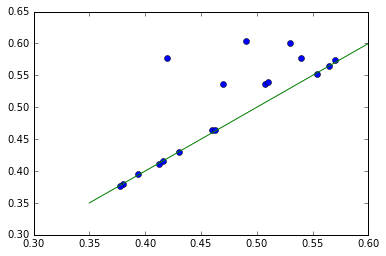

In [23]:
plt.plot(PropsDataFull.ix[:,'porosity'],PropsDataFull.ix[:,'EstPorosity'],'o')
plt.plot([0.35,0.6],[0.35,0.6])

In [24]:
PropsDataFull

bulk_density  particle_density  porosity  OM_content        k_sat  \
2360         1.420             2.573       NaN        4.86     2.083333   
2362         1.250             2.652       NaN        2.15     0.166667   
4592         1.210             2.610     0.507        3.90          NaN   
4600         1.040             2.610     0.530        3.40          NaN   
4602         1.040             2.630     0.490        2.60          NaN   
4610         1.110             2.610     0.570        3.10          NaN   
4611         1.110             2.630     0.540        3.10          NaN   
4612         1.110             2.630     0.420        3.10          NaN   
4620         1.210             2.610     0.470        3.90          NaN   
4622         1.210             2.630     0.510        3.20          NaN   
4650         1.622             2.614     0.380        0.60     4.079167   
4651         1.613             2.590     0.377        2.10    79.200000   
4660         1.370             2.560     0.460        2.31   260.640000   
4661         1.490             2.610     0.430        0.50   475.200000   
4670         1.420             2.650     0.463        0.86    37.080000   
4671         1.560             2.650     0.412        0.17     5.112083   
4672         1.610             2.660     0.394        0.17     1.007917   
4673         1.560             2.670     0.416        0.17     1.803750   
4680         1.100             2.460     0.554        3.80  1602.000000   
4681         1.080             2.480     0.565        2.90   694.800000   

      theta_sat   CEC   pH  electrolyte_level  SAR  ESP  EC  free_Fe_Al_oxide  \
2360      0.492   NaN  6.9                NaN  NaN  NaN NaN               NaN   
2362      0.557   NaN  6.7                NaN  NaN  NaN NaN               NaN   
4592        NaN   NaN  6.2                NaN  NaN  NaN NaN               NaN   
4600        NaN   NaN  6.3                NaN  NaN  NaN NaN               NaN   
4602        NaN   NaN  6.4                NaN  NaN  NaN NaN               NaN   
4610        NaN   NaN  NaN                NaN  NaN  NaN NaN               NaN   
4611        NaN   NaN  6.4                NaN  NaN  NaN NaN               NaN   
4612        NaN   NaN  6.4                NaN  NaN  NaN NaN               NaN   
4620        NaN   NaN  6.2                NaN  NaN  NaN NaN               NaN   
4622        NaN   NaN  6.2                NaN  NaN  NaN NaN               NaN   
4650      0.586   NaN  3.1                NaN  NaN  NaN NaN              0.01   
4651        NaN   NaN  4.0                NaN  NaN  NaN NaN              0.04   
4660        NaN   NaN  3.8                NaN  NaN  NaN NaN              0.31   
4661        NaN   NaN  3.9                NaN  NaN  NaN NaN              0.28   
4670        NaN   7.3  3.6                NaN  NaN  NaN NaN              0.41   
4671        NaN   7.5  3.5                NaN  NaN  NaN NaN              0.51   
4672        NaN  14.5  3.3                NaN  NaN  NaN NaN              0.93   
4673        NaN  12.1  3.4                NaN  NaN  NaN NaN              0.80   
4680        NaN   NaN  3.9                NaN  NaN  NaN NaN               NaN   
4681        NaN   NaN  3.9                NaN  NaN  NaN NaN               NaN   

      EstPorosity  
2360     0.448115  
2362     0.528658  
4592     0.536398  
4600     0.601533  
4602     0.604563  
4610     0.574713  
4611     0.577947  
4612     0.577947  
4620     0.536398  
4622     0.539924  
4650     0.379495  
4651     0.377220  
4660     0.464844  
4661     0.429119  
4670     0.464151  
4671     0.411321  
4672     0.394737  
4673     0.415730  
4680     0.552846  
4681     0.564516

### Function to fit conductivity parameters for each soil

In [25]:
#Function to fit hudraulic conductivity components and graph results.
def FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0):
    GreaterThan0 = GraphData.ix[Set,'preshead']>0
    LessThan150000 = GraphData.ix[Set,'preshead']<150000
    NonExtremities = GreaterThan0 & LessThan150000
    
    Obs_x = GraphData.ix[Set,'preshead'][NonExtremities].values
    Obs_y = np.log10(GraphData.ix[Set,'conductivity'][NonExtremities].values)

    bounds = (lower, upper)
    res = curve_fit(Condfun, Obs_x, Obs_y, bounds=bounds, p0 = p0, method ='trf', loss = 'soft_l1',verbose = 1)

    Cflow = res[0][0]
    Xflow = res[0][1]

    FitFrame = WEIRDOFunctions.ConductivityFrame(BoundPSI,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

    Fits.ix[Set,'SAT'] = FitSAT
    Fits.ix[Set,'DUL'] = FitDUL
    Fits.ix[Set,'LL'] = FitLL
    Fits.ix[Set,'psibub'] = psibub
    Fits.ix[Set,'Cflow'] = Cflow
    Fits.ix[Set,'Xflow'] = Xflow
    Fits.ix[Set,'kSat'] = FitFrame.ix[0,'Conductivity']
    Fits.ix[Set,'kFC'] = FitFrame.ix[5,'Conductivity']

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
    plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*1,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
    plt.plot(np.log10(-BoundPSI),WEIRDOFunctions.ThetaCurve_mm_5pt(BoundPSI,FitSAT,FitDUL,FitLL,psibub),label = 'WEIRDO fits')
    plt.plot([1],PropsDataFull.ix[Set,'EstPorosity'],'^',markersize = 10,label = 'Porosity')
    plt.ylim(0,0.65)
    plt.text(1.5,.58,'Soil ID ' +Set,fontsize=18)
    plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
    plt.legend()

    ymax = GraphData.ix[Set,'conductivity'][GraphData.ix[Set,'preshead']>0].max()*2
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'Conductivity'],label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
    plt.text(4,ymax*.8,'KSat = ' + '%.4g' % FitFrame.ix[0,'Conductivity'] + '\nKFC = ' + '%.4g' % FitFrame.ix[5,'Conductivity'],fontsize=16)
    plt.text(4,ymax*.65, 'KSatObs = ' + '%.4g' % PropsDataFull.ix[Set,'k_sat'],fontsize = 16)
    plt.ylim(0,ymax)
    plt.legend()

    CoeffPos =  np.log10(FitFrame.ix[:,'Conductivity'].max())*.1
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_axes([0,0,1,1])
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'Conductivity']),label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
    intLog10Cond = interpCond(GraphData.ix[Set,'preshead'][NonExtremities].values,FitFrame.ix[:,'PsiUpper'],FitFrame.ix[:,'Conductivity'])
    plt.plot(np.log10(GraphData.ix[Set,'preshead'][NonExtremities].values),intLog10Cond,'o',label = 'InterpFitPoints')
    plt.text(0.1,0.1,'Cflow = ' + '%.4g' % Cflow + '\nXflow = ' + str(Xflow)[0:5], fontsize = 16, transform=ax.transAxes)
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
    plt.xlim(1,8)
    
    plt.legend()

In [26]:
#Function to fit hudraulic conductivity components and graph results.
import matplotlib.patches as patches
def ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow):
    GreaterThan0 = GraphData.ix[Set,'preshead']>0
    LessThan150000 = GraphData.ix[Set,'preshead']<150000
    NonExtremities = GreaterThan0 & LessThan150000
    
    FitFrame = WEIRDOFunctions.ConductivityFrame(BoundPSI,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

    Fits.ix[Set,'SAT'] = FitSAT
    Fits.ix[Set,'DUL'] = FitDUL
    Fits.ix[Set,'LL'] = FitLL
    Fits.ix[Set,'psibub'] = psibub
    Fits.ix[Set,'Cflow'] = Cflow
    Fits.ix[Set,'Xflow'] = Xflow
    Fits.ix[Set,'kSat'] = FitFrame.ix[0,'Conductivity']
    Fits.ix[Set,'kFC'] = FitFrame.ix[5,'Conductivity']

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
    plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*1,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
    plt.plot(np.log10(-BoundPSI),WEIRDOFunctions.ThetaCurve_mm_5pt(BoundPSI,FitSAT,FitDUL,FitLL,psibub),label = 'WEIRDO fits')
    plt.plot([1],PropsDataFull.ix[Set,'EstPorosity'],'^',markersize = 10,label = 'Porosity')
    plt.ylim(0,0.65)
    plt.text(1.5,.58,'Soil ID ' +Set,fontsize=18)
    plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
    plt.legend()

    ymax = GraphData.ix[Set,'conductivity'][GraphData.ix[Set,'preshead']>0].max()*2
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'Conductivity'],label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
    plt.text(4,ymax*.8,'KSat = ' + '%.4g' % FitFrame.ix[0,'Conductivity'] + '\nKFC = ' + '%.4g' % FitFrame.ix[5,'Conductivity'],fontsize=16)
    plt.text(4,ymax*.65, 'KSatObs = ' + '%.4g' % PropsDataFull.ix[Set,'k_sat'],fontsize = 16)
    plt.ylim(0,ymax)
    plt.legend()

    CoeffPos =  np.log10(FitFrame.ix[:,'Conductivity'].max())*.1
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_axes([0,0,1,1])
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'Conductivity']),label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
    intLog10Cond = interpCond(GraphData.ix[Set,'preshead'][NonExtremities].values,FitFrame.ix[:,'PsiUpper'],FitFrame.ix[:,'Conductivity'])
    plt.plot(np.log10(GraphData.ix[Set,'preshead'][NonExtremities].values),intLog10Cond,'o',label = 'InterpFitPoints')
    plt.text(0.1,0.1,'Cflow = ' + '%.4g' % Cflow + '\nXflow = ' + str(Xflow)[0:5], fontsize = 16, transform=ax.transAxes)
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
    plt.xlim(1,8)
    
    plt.legend()

# Fit parameters
### Each cell below fits and graphs results for a single soil.  Moisture release points are fitted by eye to observed data to provide inputs for the hydraulic conductivit model and then Cflow and Xflow are optimised for each soil to predict hydraulic conductivity

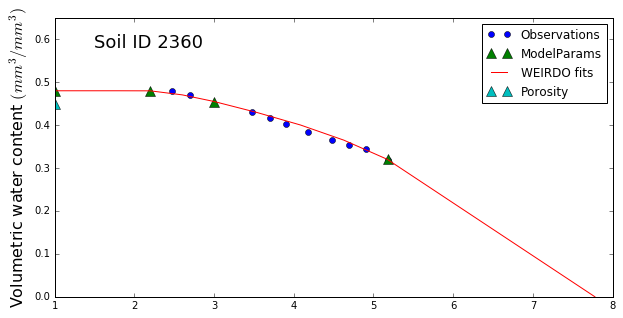

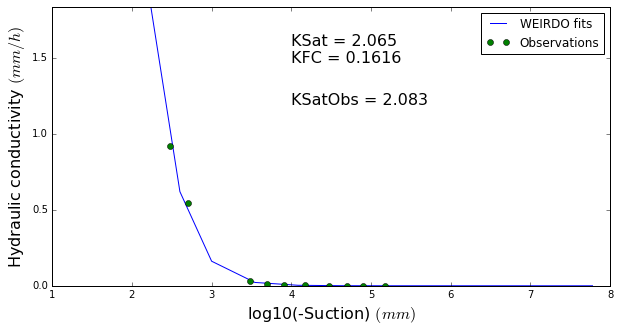

In [27]:
Set = '2360'
FitSAT = 0.48
FitDUL = 0.455
FitLL = 0.32
psibub = -155  #Should be a value between -10 and -600
lower = [0,0]
upper = [.001,10]
p0 = [6e-11,3.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-10,3.7)

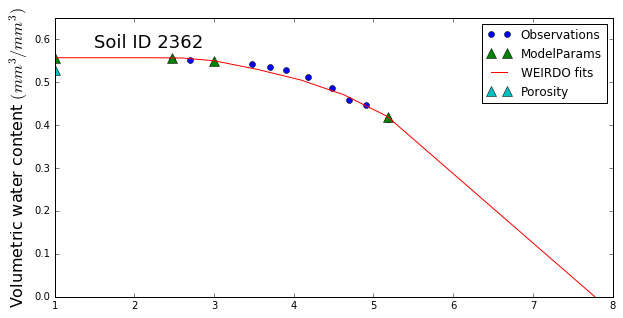

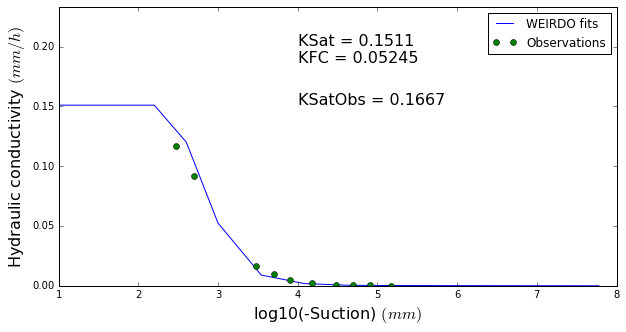

In [28]:
#Implementation Note.  When DUL is close to SAT psibub needs to be a bigger negative 
# or else the spline exceeds the value of SAT at some points, giving odd volumes
Set = '2362'
FitSAT = 0.557
FitDUL = 0.55
FitLL = 0.42
psibub = -300  #Should be a value between -10 and -600
lower = [0,0]
upper = [.001,10]
p0 = [6e-10,1.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,5e-11,3.6)

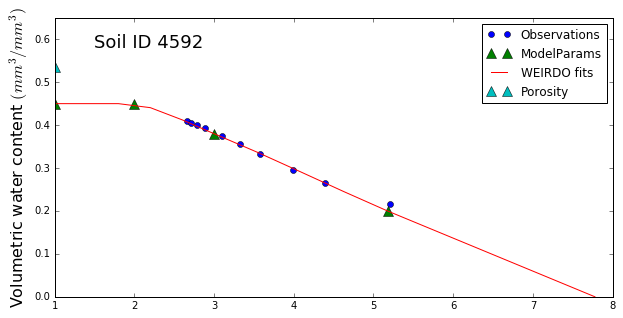

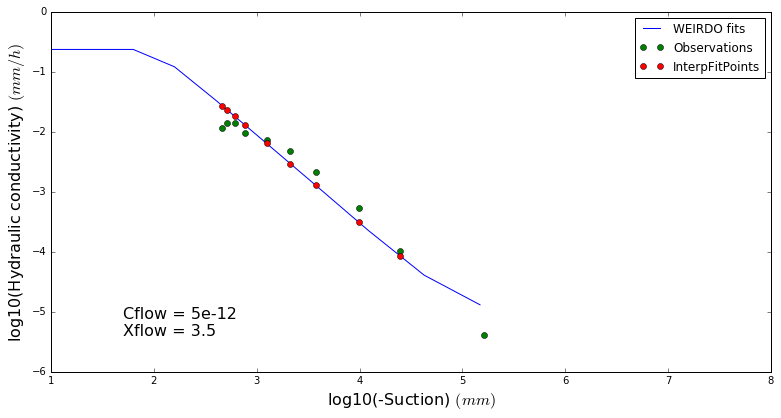

In [29]:
Set = '4592'
FitSAT = 0.45
FitDUL = 0.38
FitLL = 0.20
psibub = -100  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,2.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,5e-12,3.5)

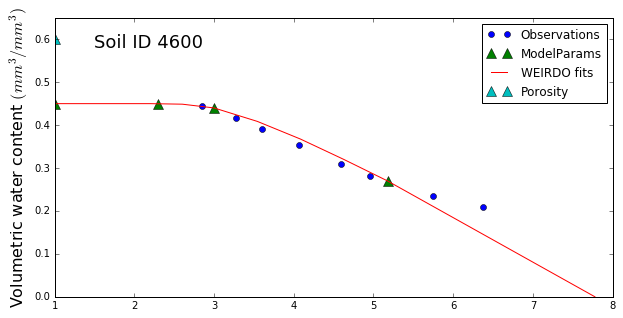

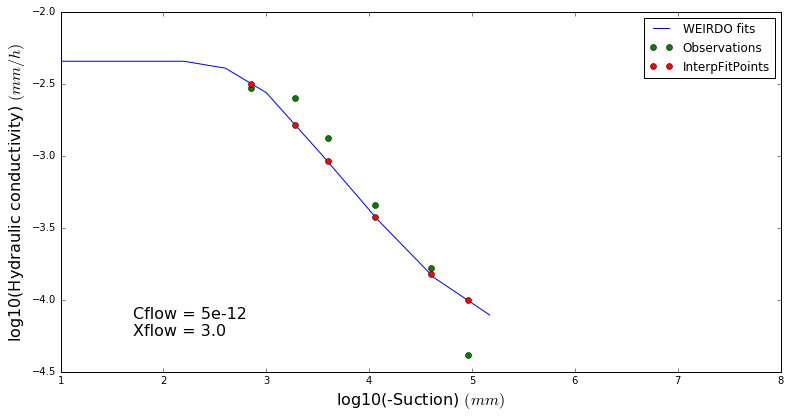

In [30]:
Set = '4600'
FitSAT = 0.45
FitDUL = 0.44
FitLL = 0.27
psibub = -200  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-12,2.7]

#ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,5e-12,3.)

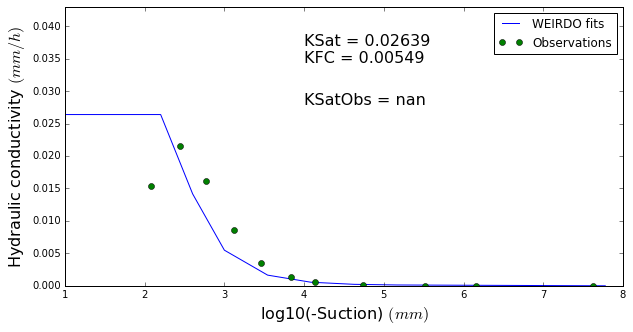

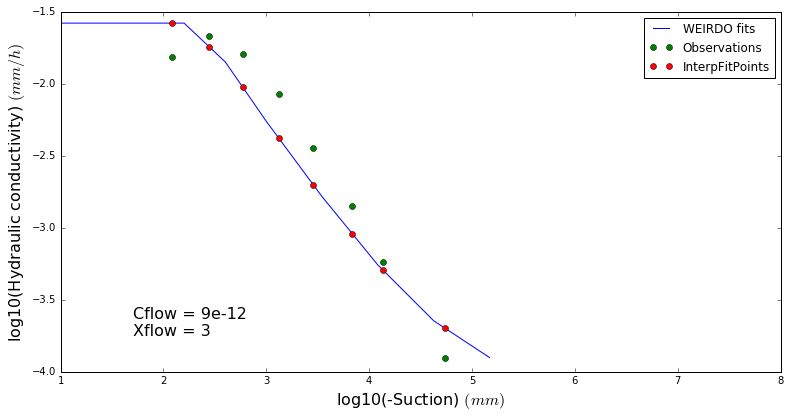

In [31]:
Set = '4602'
FitSAT = 0.45
FitDUL = 0.4
FitLL = 0.24
psibub = -200  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-10,6.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,9e-12,3)

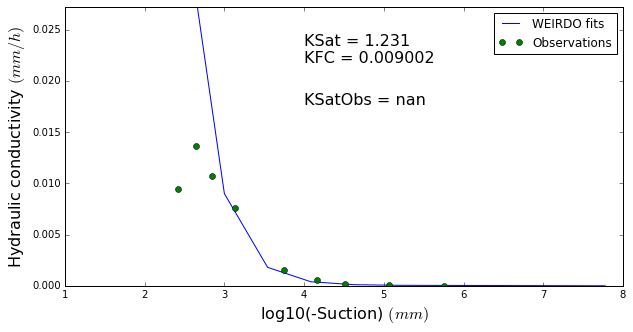

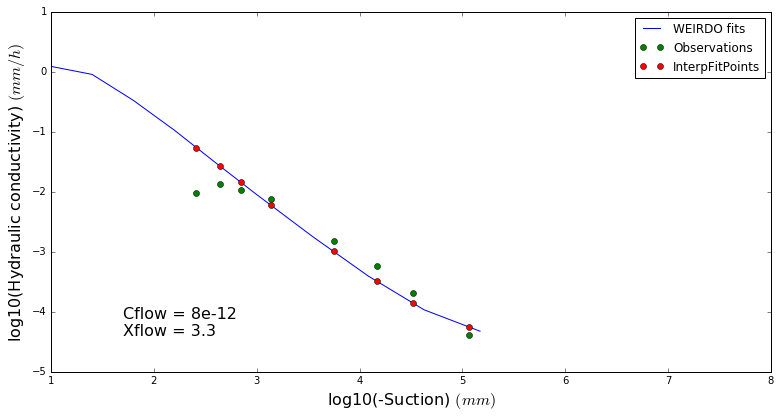

In [32]:
Set = '4610'
FitSAT = 0.55
FitDUL = 0.42
FitLL = 0.25
psibub = -20  #Should be a value between -10 and -600
lower = [0,0]
upper = [.001,10]
p0 = [6e-12,5.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,8e-12,3.3)

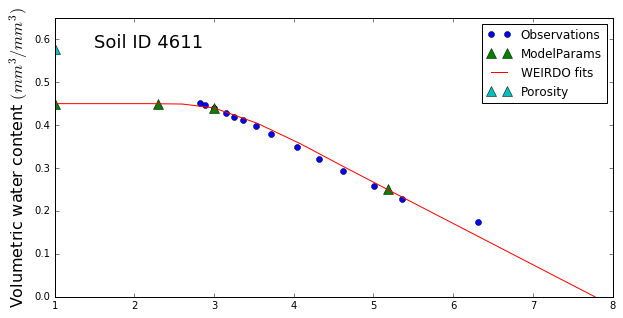

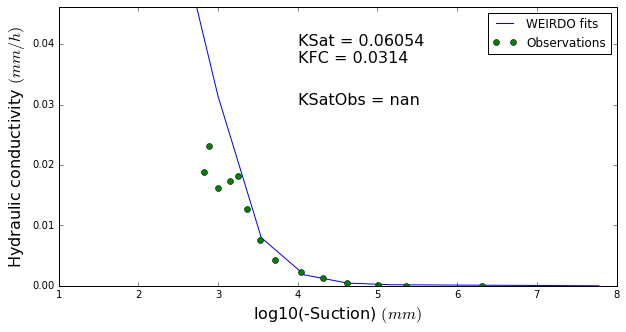

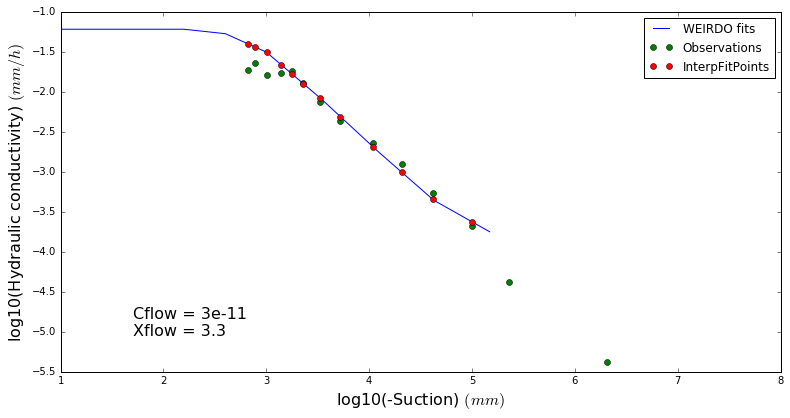

In [33]:
Set = '4611'
FitSAT = 0.45
FitDUL = 0.44
FitLL = 0.25
psibub = -200  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-12,3.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,3e-11,3.3)

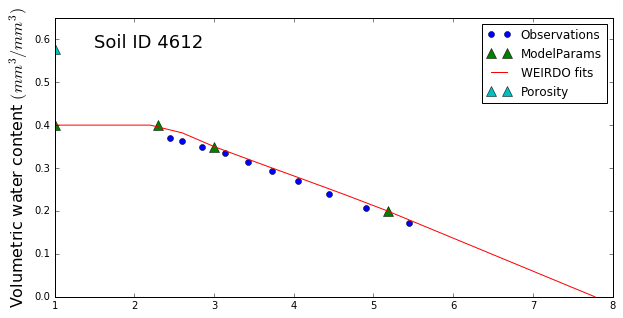

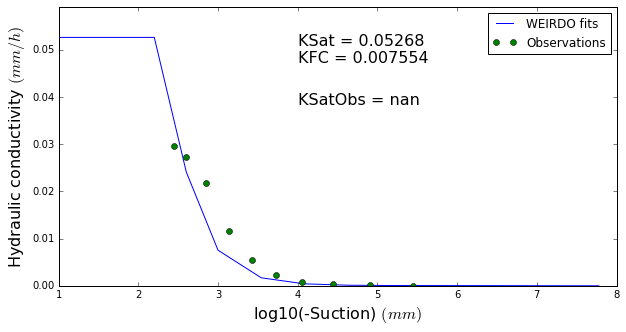

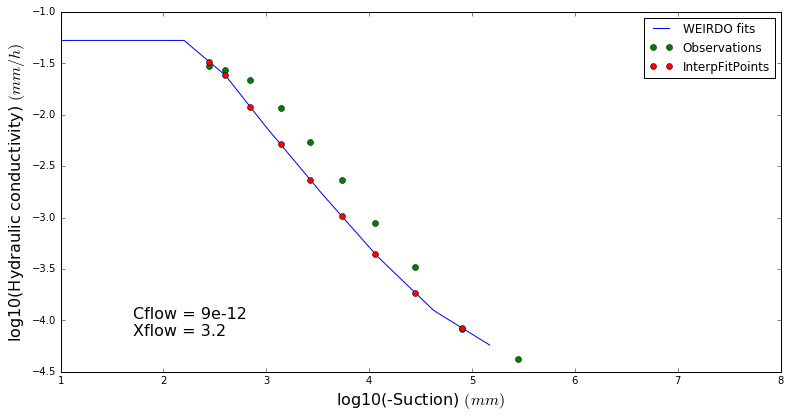

In [34]:
Set = '4612'
FitSAT = 0.4
FitDUL = 0.35
FitLL = 0.20
psibub = -200  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,2.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,9e-12,3.2)

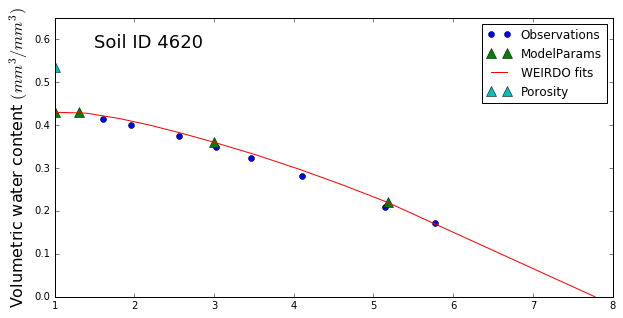

In [35]:
Set = '4620'
FitSAT = 0.43
FitDUL = 0.36
FitLL = 0.22
psibub = -20  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,10]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-11,3.1)

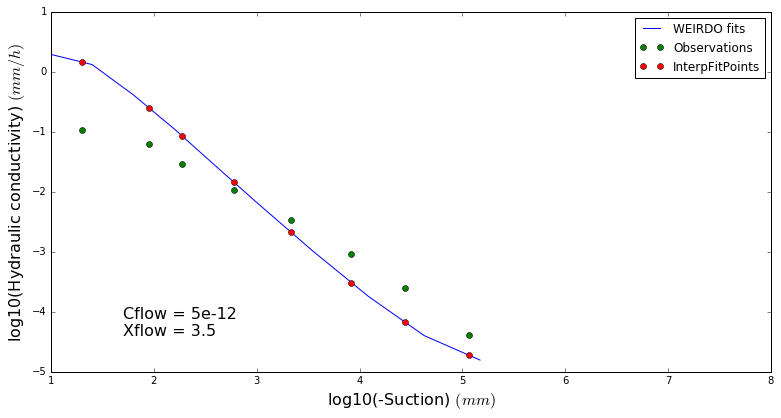

In [36]:
Set = '4622'
FitSAT = 0.48
FitDUL = 0.38
FitLL = 0.24
psibub = -20  #Should be a value between -10 and -600

lower = [0,0]
upper = [0.001,10]
p0 = [6e-12,1.9]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,5e-12,3.5)

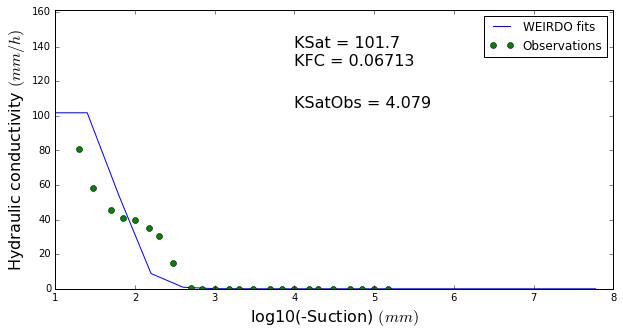

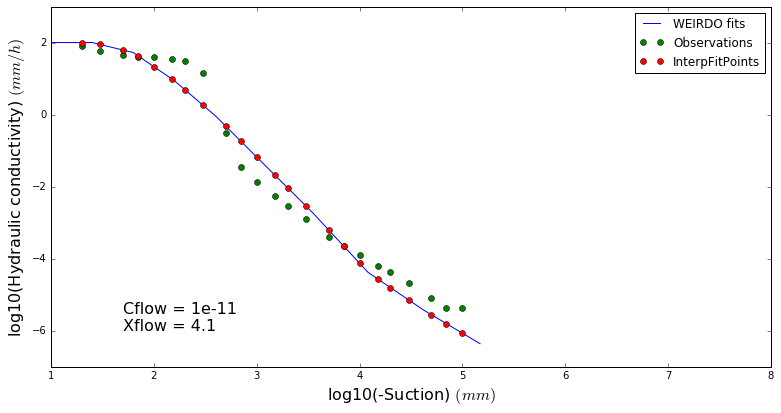

In [37]:
Set = '4650'
FitSAT = 0.38
FitDUL = 0.1
FitLL = 0.02
psibub = -50  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,1.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-11,4.1)

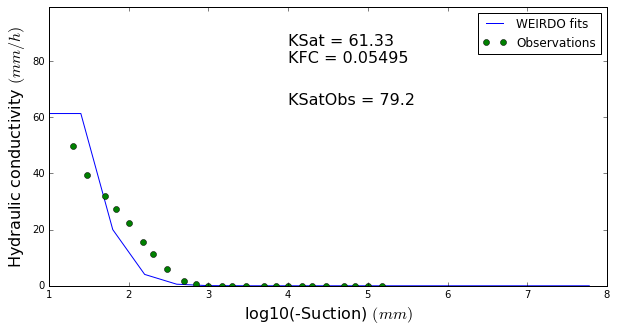

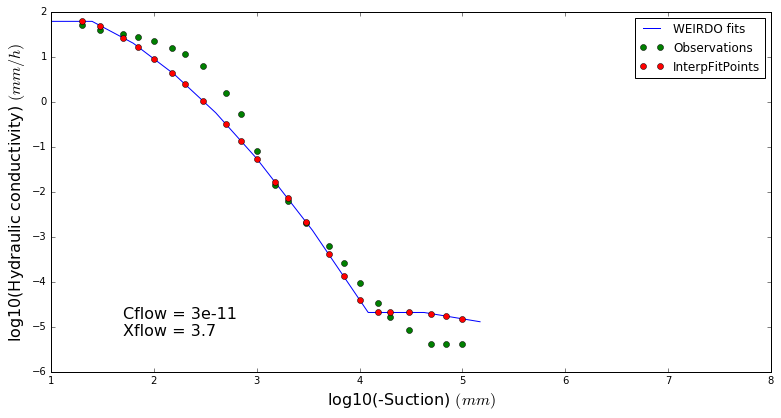

In [38]:
Set = '4651'
FitSAT = 0.36
FitDUL = 0.1
FitLL = 0.06
psibub = -30  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,2.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,3e-11,3.7)

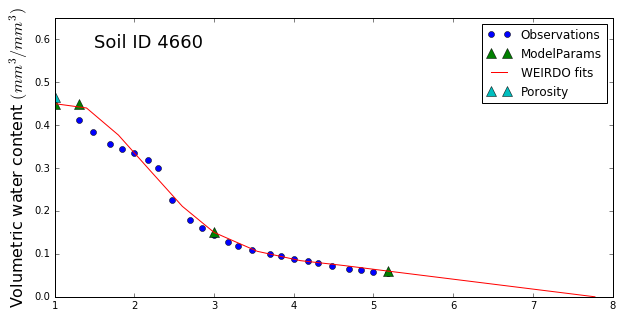

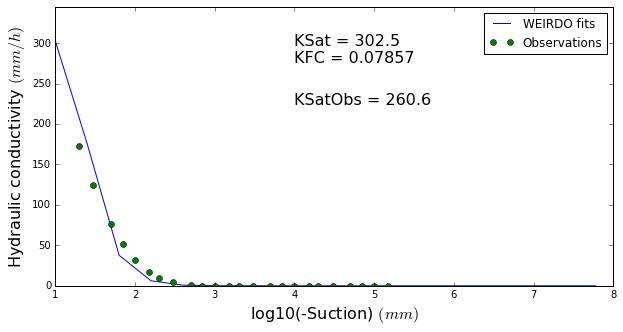

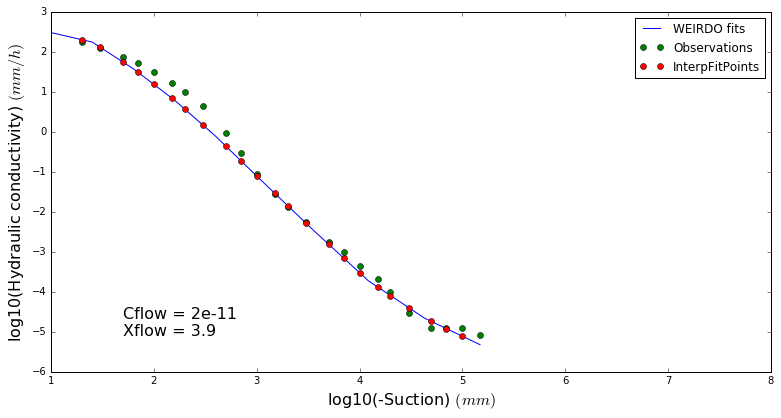

In [39]:
Set = '4660'
FitSAT = 0.45
FitDUL = 0.15
FitLL = 0.06
psibub = -20  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,3.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,2e-11,3.9)

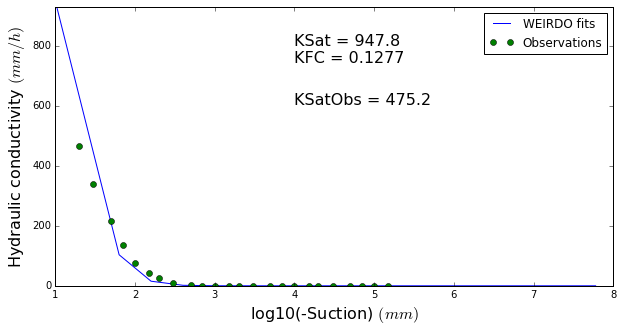

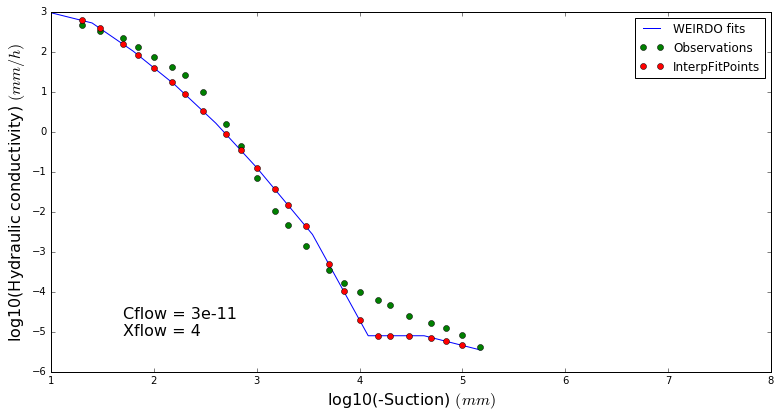

In [40]:
Set = '4661'
FitSAT = 0.42
FitDUL = 0.09
FitLL = 0.04
psibub = -20  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-12,4.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,3e-11,4)

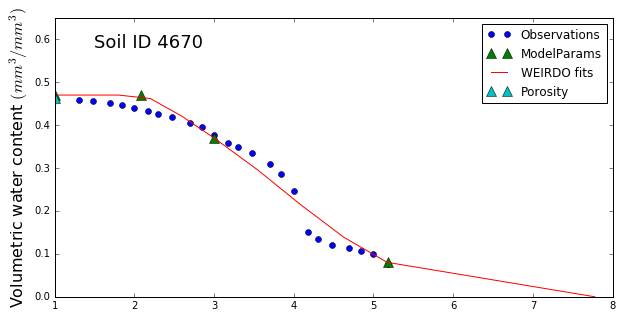

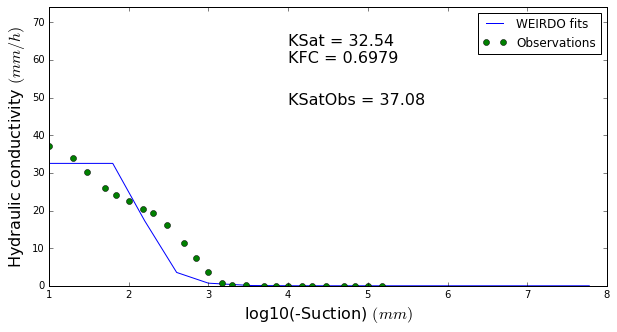

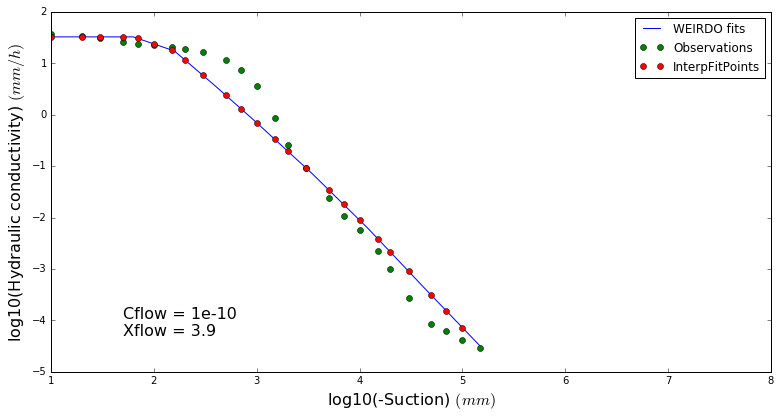

In [41]:
Set = '4670'
FitSAT = 0.47
FitDUL = 0.37
FitLL = 0.08
psibub = -120  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,4.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-10,3.9)

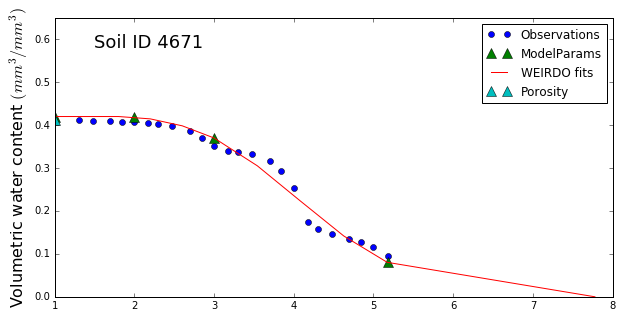

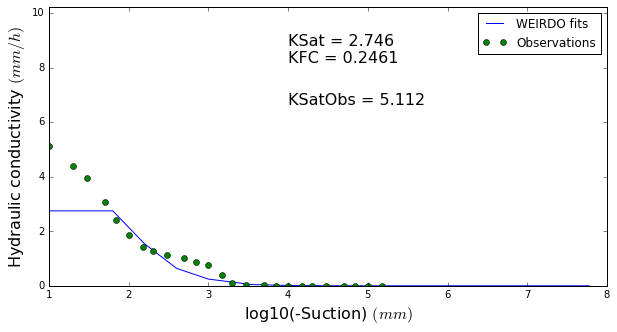

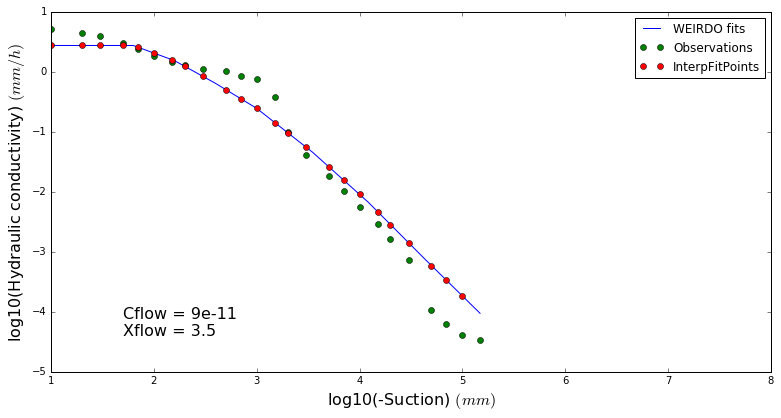

In [42]:
Set = '4671'
FitSAT = 0.42
FitDUL = 0.37
FitLL = 0.08
psibub = -100  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,3.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,9e-11,3.5)

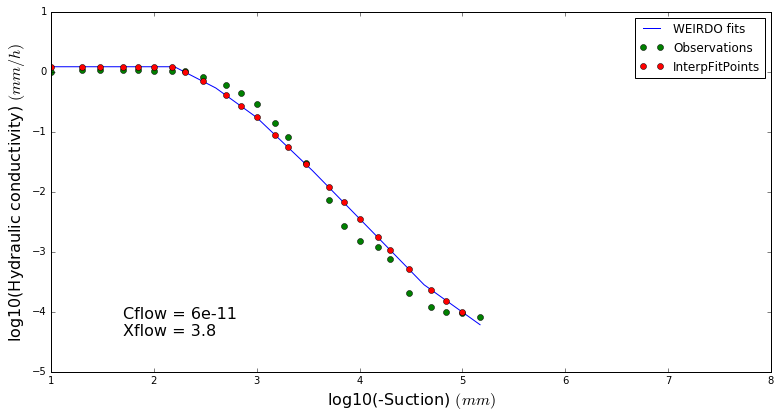

In [43]:
Set = '4672'
FitSAT = 0.39
FitDUL = 0.37
FitLL = 0.19
psibub = -200  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,3.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,6e-11,3.8)

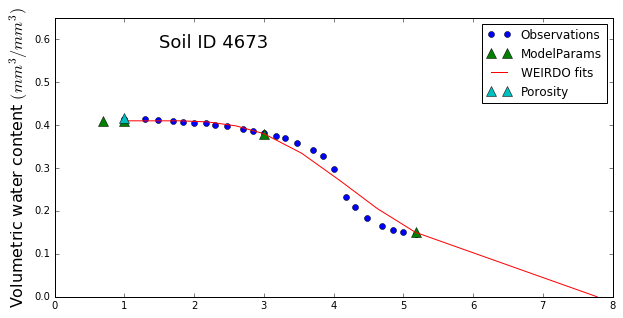

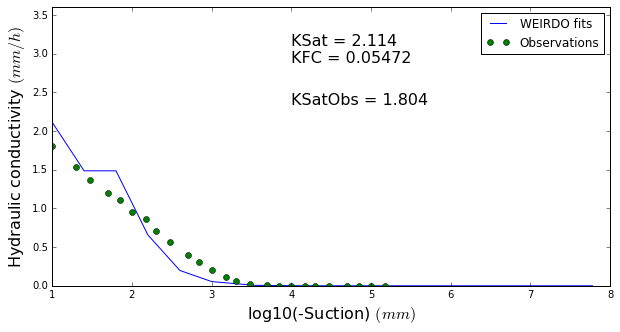

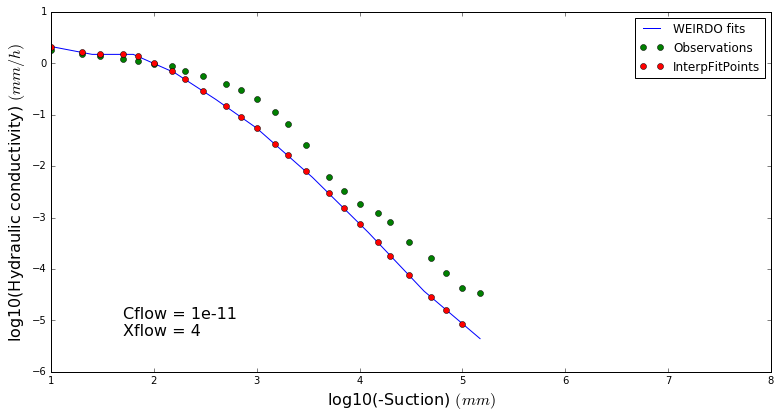

In [44]:
Set = '4673'
FitSAT = 0.41
FitDUL = 0.38
FitLL = 0.15
psibub = -5  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,4.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-11,4)

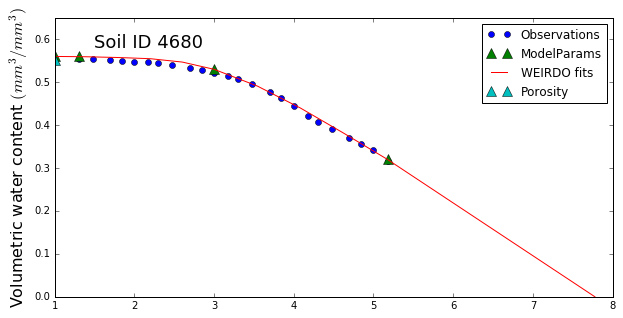

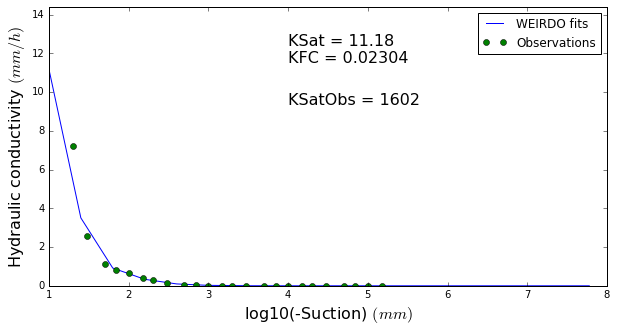

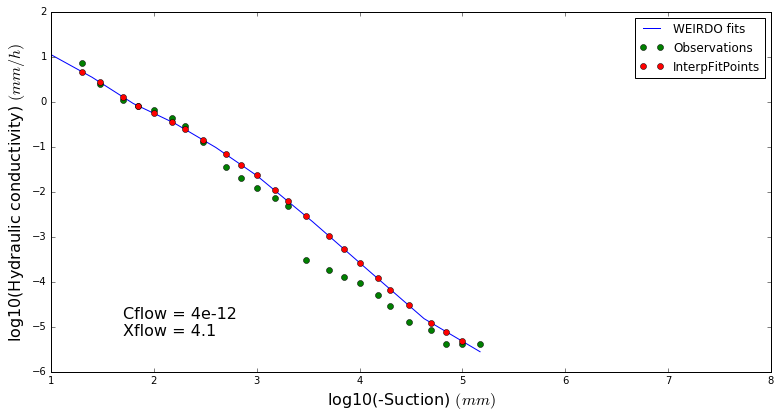

In [45]:
Set = '4680'
FitSAT = 0.56
FitDUL = 0.53
FitLL = 0.32
psibub = -20  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [1.2e-11,0.8]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,4e-12,4.1)

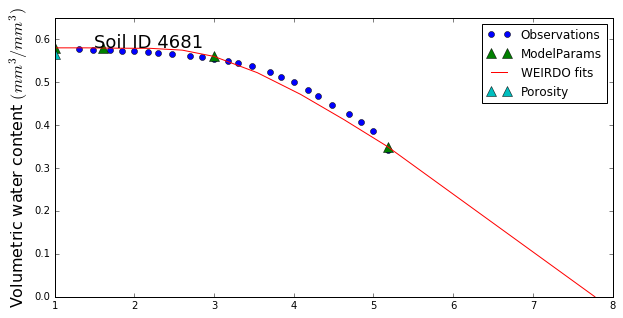

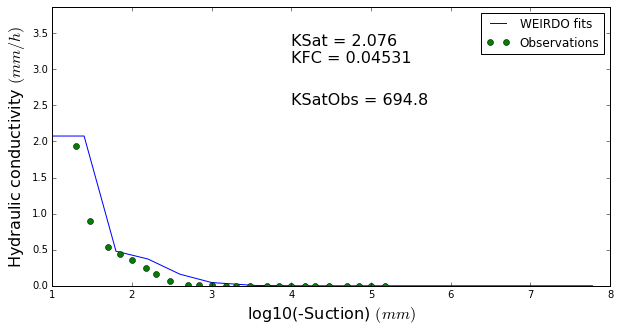

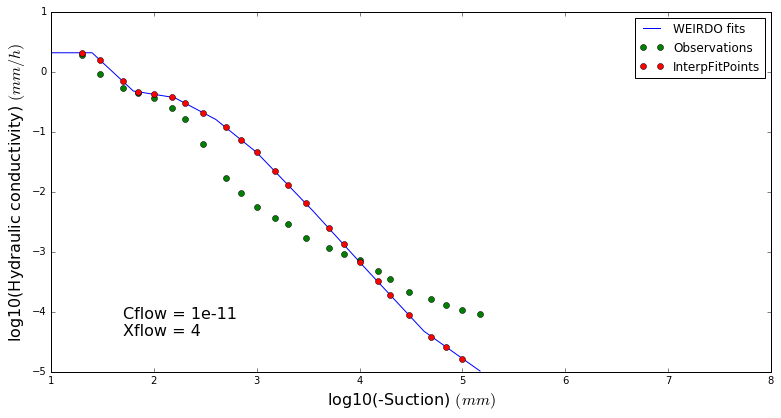

In [46]:
Set = '4681'
FitSAT = 0.58
FitDUL = 0.56
FitLL = 0.35
psibub = -40  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,0.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-11,4)

In [47]:
Fits.ix[:,'MacroPorosity'] = Fits.ix[:,'SAT'] - Fits.ix[:,'DUL']
Fits.ix[:,'MatrixPorosity'] = Fits.ix[:,'DUL'] - Fits.ix[:,'LL']

In [48]:
Fits.ix[:,'Sand'] = np.nan
Fits.ix[:,'Silt'] = np.nan
Fits.ix[:,'Clay'] = np.nan
for soil in Fits.index:
    Fits.ix[soil,'Sand'] = Texture.ix[int(soil),'Sand']
    Fits.ix[soil,'Silt'] = Texture.ix[int(soil),'Silt']
    Fits.ix[soil,'Clay'] = Texture.ix[int(soil),'Clay']

In [49]:
Fits

SAT    DUL    LL psibub  Cflow Xflow        kSat         kFC  \
2360   0.48  0.455  0.32   -155  1e-10   3.7     2.06547    0.161591   
2362  0.557   0.55  0.42   -300  5e-11   3.6    0.151075   0.0524529   
4592   0.45   0.38   0.2   -100  5e-12   3.5    0.235892  0.00885503   
4600   0.45   0.44  0.27   -200  5e-12     3  0.00453403  0.00274449   
4602   0.45    0.4  0.24   -200  9e-12     3   0.0263936  0.00549045   
4610   0.55   0.42  0.25    -20  8e-12   3.3     1.23143  0.00900174   
4611   0.45   0.44  0.25   -200  3e-11   3.3   0.0605412    0.031397   
4612    0.4   0.35   0.2   -200  9e-12   3.2   0.0526761  0.00755364   
4620   0.43   0.36  0.22    -20  1e-11   3.1    0.245984   0.0058948   
4622   0.48   0.38  0.24    -20  5e-12   3.5     1.94802  0.00665017   
4650   0.38    0.1  0.02    -50  1e-11   4.1     101.733   0.0671308   
4651   0.36    0.1  0.06    -30  3e-11   3.7     61.3321   0.0549504   
4660   0.45   0.15  0.06    -20  2e-11   3.9     302.465   0.0785675   
4661   0.42   0.09  0.04    -20  3e-11     4     947.837    0.127679   
4670   0.47   0.37  0.08   -120  1e-10   3.9     32.5369    0.697875   
4671   0.42   0.37  0.08   -100  9e-11   3.5     2.74617     0.24608   
4672   0.39   0.37  0.19   -200  6e-11   3.8     1.21417    0.173498   
4673   0.41   0.38  0.15     -5  1e-11     4     2.11434    0.054721   
4680   0.56   0.53  0.32    -20  4e-12   4.1     11.1764    0.023041   
4681   0.58   0.56  0.35    -40  1e-11     4     2.07573   0.0453066   

     MacroPorosity MatrixPorosity   Sand   Silt   Clay  
2360         0.025          0.135  0.320  0.230  0.450  
2362         0.007           0.13  0.080  0.290  0.630  
4592          0.07           0.18  0.360  0.400  0.240  
4600          0.01           0.17  0.360  0.400  0.240  
4602          0.05           0.16  0.370  0.390  0.240  
4610          0.13           0.17  0.360  0.400  0.240  
4611          0.01           0.19  0.370  0.390  0.240  
4612          0.05           0.15  0.370  0.390  0.240  
4620          0.07           0.14  0.360  0.400  0.240  
4622           0.1           0.14  0.370  0.390  0.240  
4650          0.28           0.08  0.920  0.070  0.010  
4651          0.26           0.04  0.950  0.040  0.010  
4660           0.3           0.09  0.910  0.050  0.040  
4661          0.33           0.05  0.920  0.050  0.030  
4670           0.1           0.29  0.030  0.900  0.070  
4671          0.05           0.29  0.030  0.880  0.090  
4672          0.02           0.18  0.060  0.760  0.180  
4673          0.03           0.23  0.050  0.810  0.140  
4680          0.03           0.21  0.109  0.418  0.473  
4681          0.02           0.21  0.112  0.344  0.544

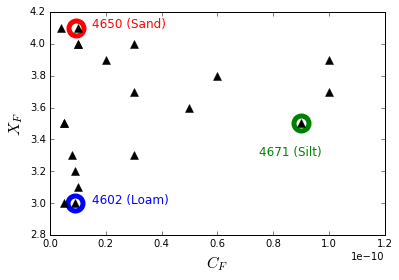

In [50]:
plt.plot([9.5e-12],[4.1],'o',markersize=15,mfc='w',mec='r',mew=5)
plt.text(1.5e-11,4.1,'4650 (Sand)',color='r',fontsize=12)
plt.plot([9e-12],[3],'o',markersize=15,mfc='w',mec='b',mew=5)
plt.text(1.5e-11,3,'4602 (Loam)',color='b',fontsize=12)
plt.plot([9e-11],[3.5],'o',markersize=15,mfc='w',mec='g',mew=5)
plt.text(7.5e-11,3.3,'4671 (Silt)',color='g',fontsize=12)
#plt.plot([7e-11],[3],'o',markersize=15,mfc='w',mec='deepskyblue',mew=5)
plt.plot(Fits.Cflow,Fits.Xflow,'^k',label='UNSODA',markersize=8)
#plt.plot([8e-12,6e-12,7e-12,7e-12],[3.9,3.8,3.7,3.6],'^g',label='Baxters',markersize=8)
#plt.plot([4e-10,7e-11],[3.2,3],'^b',label='Ablock',markersize=8)
plt.xlim(0,1.2e-10)
plt.ylim(2.8,4.2)
#plt.legend()
plt.xlabel(r'$C_F$',fontsize=16)
plt.ylabel(r'$X_F$',fontsize=16)

In [51]:
Fits.Cflow.values

array([1e-10, 5e-11, 5e-12, 5e-12, 9e-12, 8e-12, 3e-11, 9e-12, 1e-11,
       5e-12, 1e-11, 3e-11, 2e-11, 3e-11, 1e-10, 9e-11, 6e-11, 1e-11,
       4e-12, 1e-11], dtype=object)

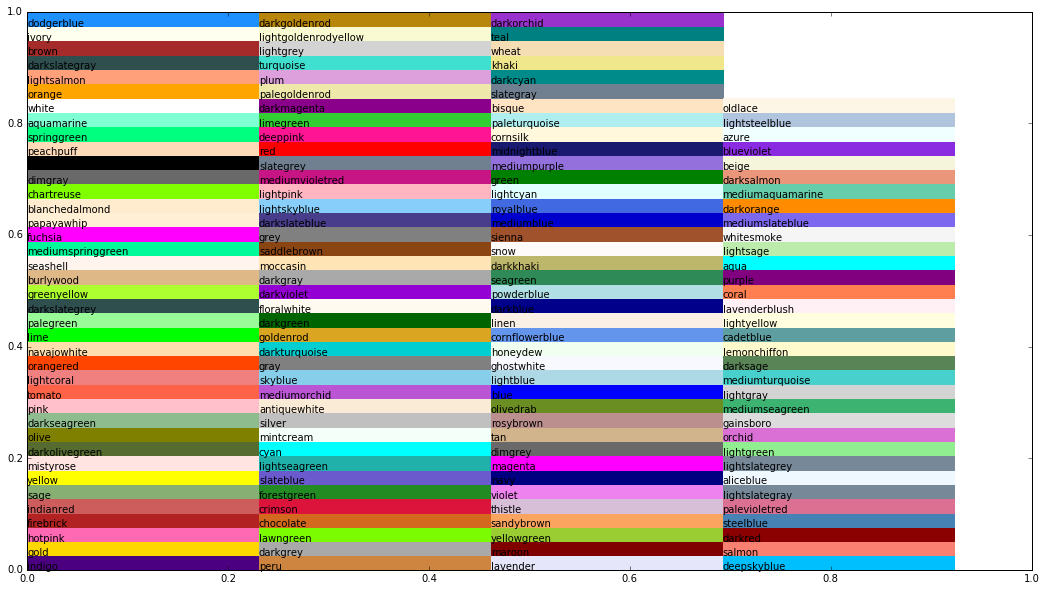

In [52]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import math


fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)

ratio = 1.0 / 3.0
count = math.ceil(math.sqrt(len(colors.cnames)))
x_count = count * ratio
y_count = count / ratio
x = 0
y = 0
w = 1 / x_count
h = 1 / y_count

for c in colors.cnames:
    pos = (x / x_count, y / y_count)
    ax.add_patch(patches.Rectangle(pos, w, h, color=c))
    ax.annotate(c, xy=pos)
    if y >= y_count-1:
        x += 1
        y = 0
    else:
        y += 1

plt.show()

In [53]:
import matplotlib
for name, hex in matplotlib.colors.cnames.iteritems():
    print(name, hex)

(u'indigo', u'#4B0082')
(u'gold', u'#FFD700')
(u'hotpink', u'#FF69B4')
(u'firebrick', u'#B22222')
(u'indianred', u'#CD5C5C')
(u'sage', u'#87AE73')
(u'yellow', u'#FFFF00')
(u'mistyrose', u'#FFE4E1')
(u'darkolivegreen', u'#556B2F')
(u'olive', u'#808000')
(u'darkseagreen', u'#8FBC8F')
(u'pink', u'#FFC0CB')
(u'tomato', u'#FF6347')
(u'lightcoral', u'#F08080')
(u'orangered', u'#FF4500')
(u'navajowhite', u'#FFDEAD')
(u'lime', u'#00FF00')
(u'palegreen', u'#98FB98')
(u'darkslategrey', u'#2F4F4F')
(u'greenyellow', u'#ADFF2F')
(u'burlywood', u'#DEB887')
(u'seashell', u'#FFF5EE')
(u'mediumspringgreen', u'#00FA9A')
(u'fuchsia', u'#FF00FF')
(u'papayawhip', u'#FFEFD5')
(u'blanchedalmond', u'#FFEBCD')
(u'chartreuse', u'#7FFF00')
(u'dimgray', u'#696969')
(u'black', u'#000000')
(u'peachpuff', u'#FFDAB9')
(u'springgreen', u'#00FF7F')
(u'aquamarine', u'#7FFFD4')
(u'white', u'#FFFFFF')
(u'orange', u'#FFA500')
(u'lightsalmon', u'#FFA07A')
(u'darkslategray', u'#2F4F4F')
(u'brown', u'#A52A2A')
(u'ivory', u'#F

<Container object of 20 artists>

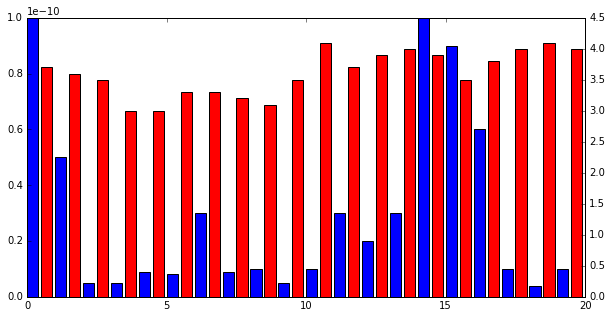

In [54]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.bar(left = range(Fits.index.size),height = Fits.Cflow, width = 0.4)
ax2.bar(left = np.add(0.5,range(Fits.index.size)),height = Fits.Xflow, width = 0.4,color='r')

<Container object of 20 artists>

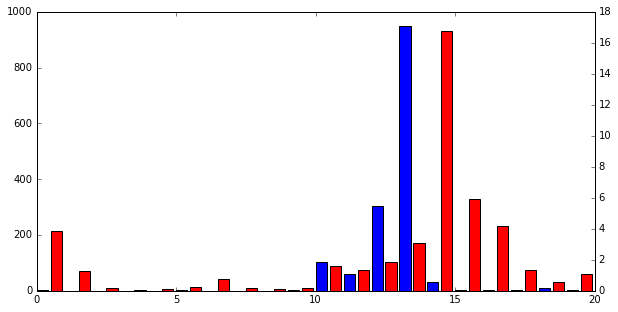

In [55]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.bar(left = range(Fits.index.size),height = Fits.kSat, width = 0.4)
ax2.bar(left = np.add(0.5,range(Fits.index.size)),height = Fits.kFC*24, width = 0.4,color='r')

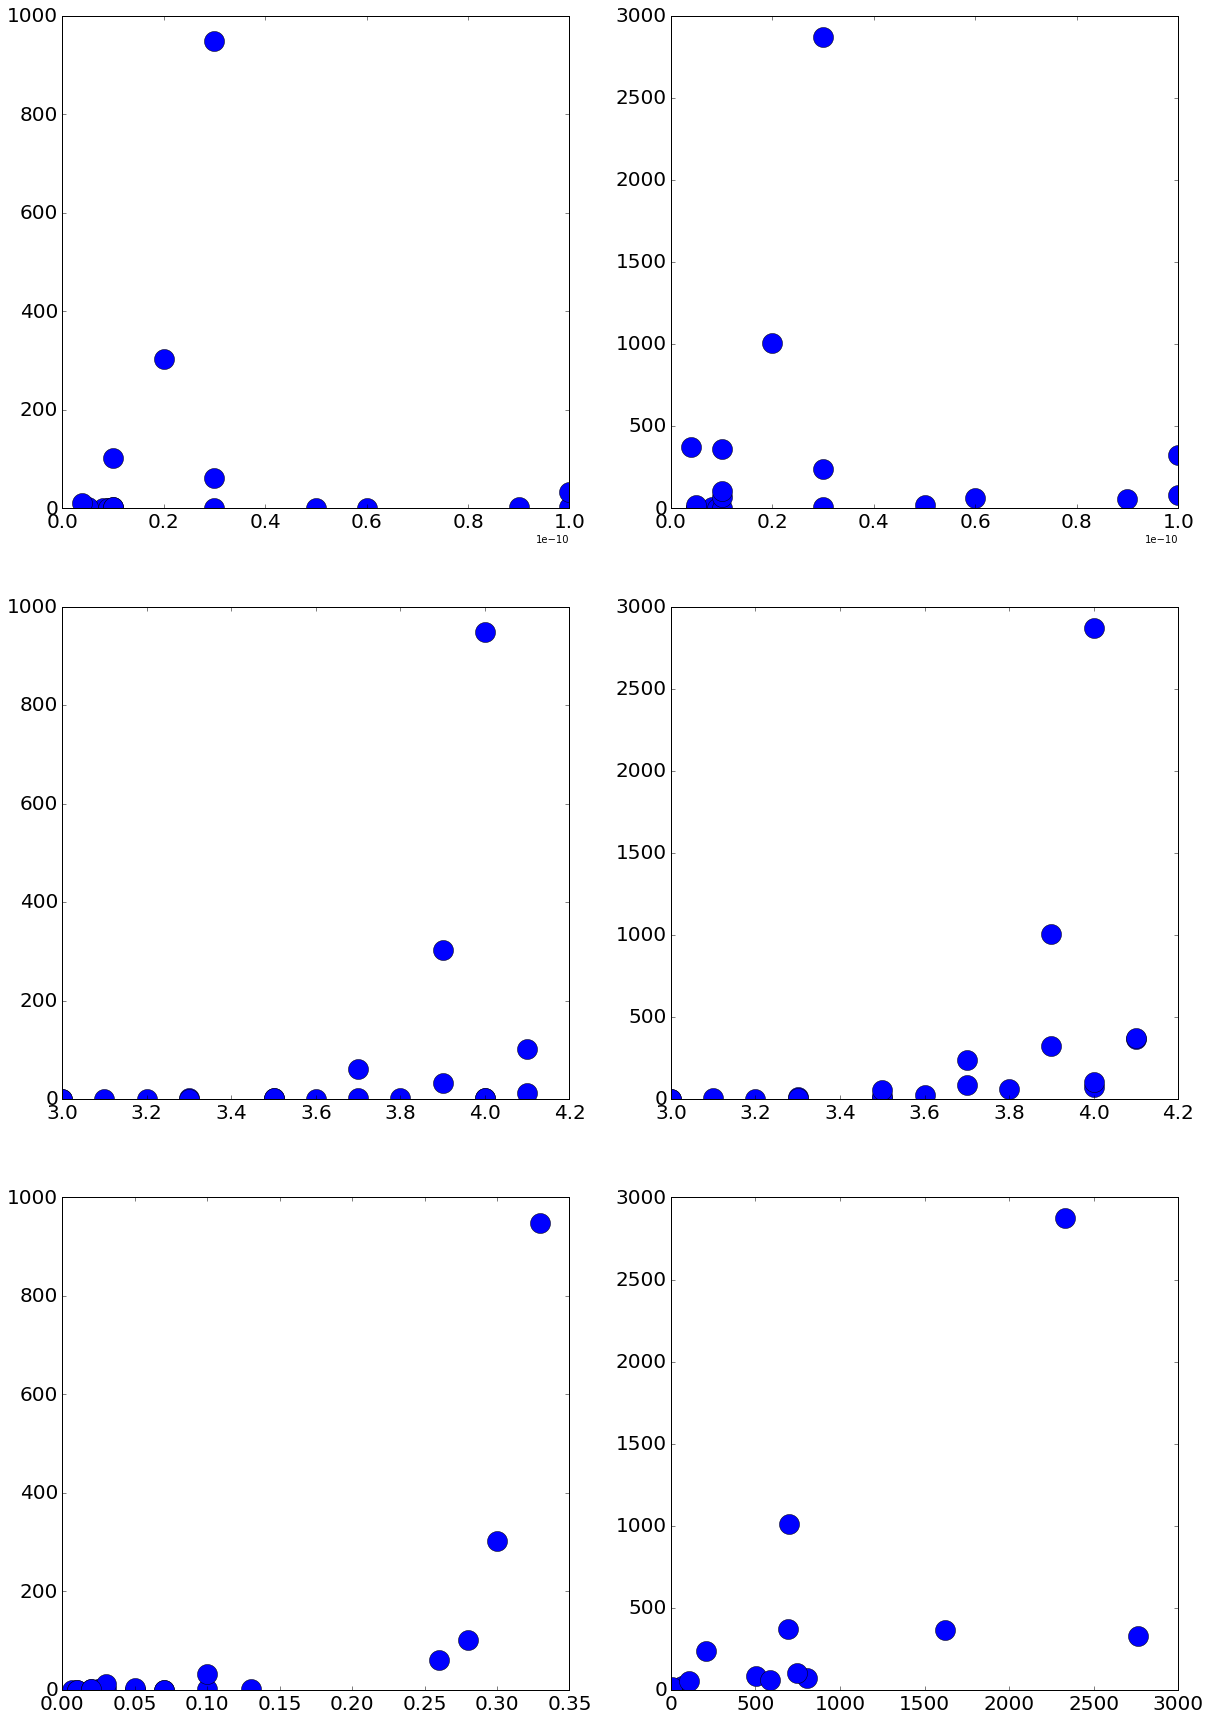

In [56]:
fig = plt.figure(figsize=(20,30))
fig.add_subplot(3,2,1)
plt.plot(Fits.Cflow,Fits.kSat,'o',markersize=20)
plt.tick_params(labelsize=20)
fig.add_subplot(3,2,3)
plt.plot(Fits.Xflow,Fits.kSat,'o',markersize=20)
plt.tick_params(labelsize=20)
fig.add_subplot(3,2,5)
plt.plot(Fits.MacroPorosity,Fits.kSat,'o',markersize=20)
plt.tick_params(labelsize=20)
fig.add_subplot(3,2,2)
plt.plot(Fits.Cflow,Fits.kSat/Fits.MacroPorosity,'o',markersize=20)
plt.tick_params(labelsize=20)
fig.add_subplot(3,2,4)
plt.plot(Fits.Xflow,Fits.kSat/Fits.MacroPorosity,'o',markersize=20)
plt.tick_params(labelsize=20)
fig.add_subplot(3,2,6)
plt.plot(Fits.Cflow * np.power(3000,Fits.Xflow)*(1-(-Fits.psibub/500)),Fits.kSat/Fits.MacroPorosity,'o',markersize=20)
plt.tick_params(labelsize=20)

In [57]:
1-(-Fits.psibub/500)

2360    0.69
2362     0.4
4592     0.8
4600     0.6
4602     0.6
4610    0.96
4611     0.6
4612     0.6
4620    0.96
4622    0.96
4650     0.9
4651    0.94
4660    0.96
4661    0.96
4670    0.76
4671     0.8
4672     0.6
4673    0.99
4680    0.96
4681    0.92
Name: psibub, dtype: object

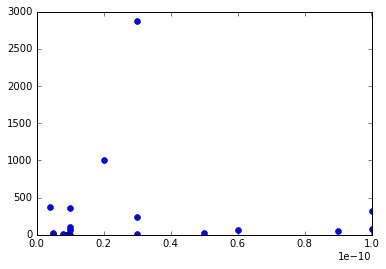

In [58]:
plt.plot(Fits.Cflow,Fits.kSat/Fits.MacroPorosity,'o')

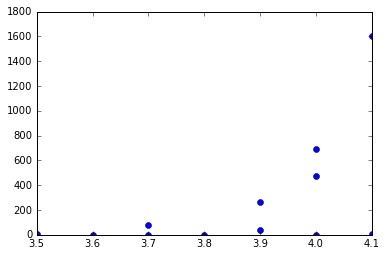

In [59]:
plt.plot(Fits.Xflow,PropsDataFull.k_sat,'o')

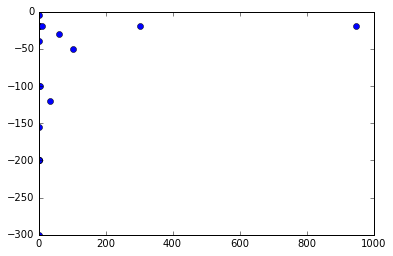

In [60]:
plt.plot(Fits.ix[:,'kSat'],Fits.ix[:,'psibub'],'o')

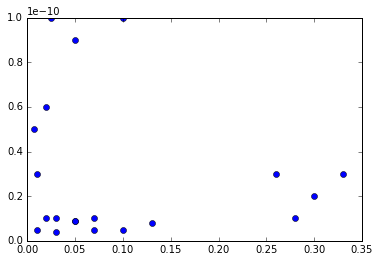

In [61]:
plt.plot(Fits.ix[:,'MacroPorosity'],Fits.ix[:,'Cflow'],'o')

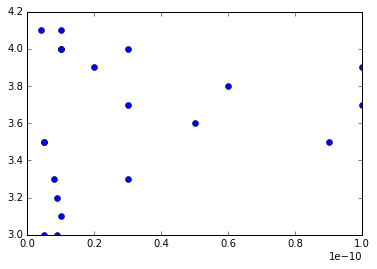

In [62]:
plt.plot(Fits.ix[:,'Cflow'],Fits.ix[:,'Xflow'],'o')

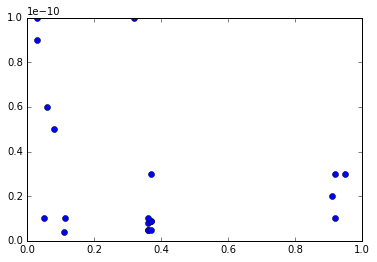

In [63]:
plt.plot(Fits.ix[:,'Sand'],Fits.ix[:,'Cflow'],'o')

In [64]:
LLConductFilter = FullData.preshead == 150000
LLConduct = FullData.ix[LLConductFilter,'conductivity']
LLConduct.name = 'LLConduct'
FCConductFilter = (FullData.preshead >= 800) & (FullData.preshead <=1250)
FCConduct = FullData.ix[FCConductFilter,'conductivity']
FCConduct.name = 'FCConduct'

In [65]:
PointConductivityies = pd.concat([LLConduct,FCConduct],axis=1,names = ['LLCond','FCCond'])
for soil in PointConductivityies.index:
    PointConductivityies.ix[soil,'Sand'] = Texture.ix[soil,'Sand']
    PointConductivityies.ix[soil,'Silt'] = Texture.ix[soil,'Silt']
    PointConductivityies.ix[soil,'Clay'] = Texture.ix[soil,'Clay']

In [66]:
PointConductivityies

LLConduct  FCConduct   Sand   Silt   Clay
code                                           
2360   0.000167        NaN  0.320  0.230  0.450
2362   0.000100        NaN  0.080  0.290  0.630
4592        NaN   0.007287  0.360  0.400  0.240
4611        NaN   0.016167  0.370  0.390  0.240
4620        NaN   0.006667  0.360  0.400  0.240
4650   0.000000   0.013679  0.920  0.070  0.010
4651   0.000000   0.080625  0.950  0.040  0.010
4660   0.000008   0.090375  0.910  0.050  0.040
4661   0.000004   0.068750  0.920  0.050  0.030
4670   0.000029   3.672083  0.030  0.900  0.070
4671   0.000033   0.759583  0.030  0.880  0.090
4672   0.000083   0.285833  0.060  0.760  0.180
4673   0.000033   0.202333  0.050  0.810  0.140
4680   0.000004   0.012058  0.109  0.418  0.473
4681   0.000092   0.005579  0.112  0.344  0.544

In [67]:
PointConductivityies.LLConduct.max()

0.00016666666666666666

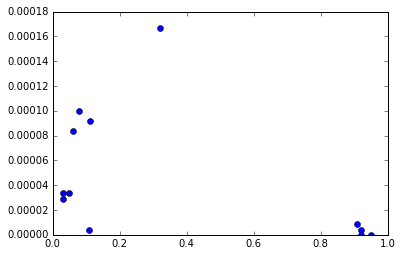

In [68]:
plt.plot(PointConductivityies.Sand,PointConductivityies.LLConduct,'o')

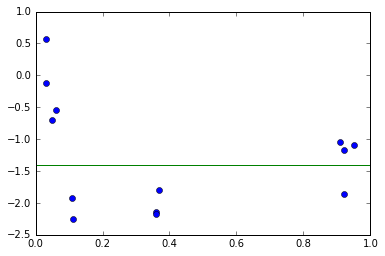

In [69]:
plt.plot(PointConductivityies.Sand,np.log10(PointConductivityies.FCConduct),'o')
#plt.ylim(0,1)
plt.plot([0,1],np.log10([0.04,0.04]))

In [70]:
PointConductivityies.FCConduct

code
2360         NaN
2362         NaN
4592    0.007287
4611    0.016167
4620    0.006667
4650    0.013679
4651    0.080625
4660    0.090375
4661    0.068750
4670    3.672083
4671    0.759583
4672    0.285833
4673    0.202333
4680    0.012058
4681    0.005579
Name: FCConduct, dtype: float64

# Bring in Data from Baxters 
### Moisture release data points at kPa potential
### K curve data point at mmH20 potential

In [71]:
Baxters = pd.read_pickle('Baxters.pkl')
Baxters.set_index(['Depth','Site'],inplace=True)
Baxters.sort_index(inplace=True)

In [72]:
PoreBounds = [ 3000, 1194, 475, 189, 75, 30, 8.6, 2.47, 0.707, 0.202, 0.0005 ]

BoundPSImm =  np.divide(-30000,PoreBounds)
BoundPSIcm =  np.divide(-3000,PoreBounds)

BoundrySuction = [1,1,1.4,1.4,1.8,1.8,2.2,2.2,2.6,2.6,3,3,3.54,3.54,4.085,4.085,4.6275,4.6275,5.17,5.17,5.77,7.77]
BoundryMarkers = [-10000,10000,10000,-10000,-10000,10000,10000,-10000,-10000,10000,10000,-10000,-10000,10000,10000,-10000,-10000,10000,10000,-10000,-10000,10000]

In [73]:
def FitArryK(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,MRP,kP,MRD,kD):
    
    FitFrame = WEIRDOFunctions.ConductivityFrame(BoundPSI,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
    
    fig = plt.figure(figsize=(10,5))
    for samp in MRD.index:
        plt.plot(np.log10(MRP),MRD.ix[samp,:]/100,'o')
    plt.plot(np.log10([10,-psibub,1000,150000,6e7]),[FitSAT,FitSAT,FitDUL,FitLL,0],'^',markersize = 10,label = 'ModelParams')
    plt.plot(np.log10(-BoundPSI),WEIRDOFunctions.ThetaCurve_mm_5pt(BoundPSI,FitSAT,FitDUL,FitLL,psibub),label = 'WEIRDO fits')
    plt.plot(BoundrySuction,BoundryMarkers,'--',color='grey')
    plt.ylim(0,0.65)
    plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
    plt.legend()

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'Conductivity'],label = 'WEIRDO fits')
    plt.plot(np.log10([1000,150000]),[1.0/24.0,.00001],'^',color='red', markersize=15)
    for samp in kD.index:
        plt.plot(np.log10(kP),kD.ix[samp,:],'o')
    plt.plot(BoundrySuction,BoundryMarkers,'--',color='grey')
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
    plt.legend()
    plt.ylim(0,kD.max().max()*1.2)

    CoeffPos =  np.log10(FitFrame.ix[:,'Conductivity'].max())*.1
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_axes([0,0,1,1])
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'Conductivity']),label = 'WEIRDO fits')
    plt.plot(np.log10([1000,1000,150000,150000]),np.log10([4,0.005,0.0002,0.000001]),'^',color='red', markersize=15)
    for samp in kD.index:
        plt.plot(np.log10(kP),np.log10(kD.ix[samp,:]),'o')
    plt.plot(BoundrySuction,BoundryMarkers,'--',color='grey')
    plt.text(0.1,0.1,'Cflow = ' + '%.4g' % Cflow + '\nXflow = ' + str(Xflow)[0:5], fontsize = 16, transform=ax.transAxes)
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
    plt.xlim(1,8)
    plt.ylim(-6,np.log10(kD.max().max())*1.2)

    plt.legend()

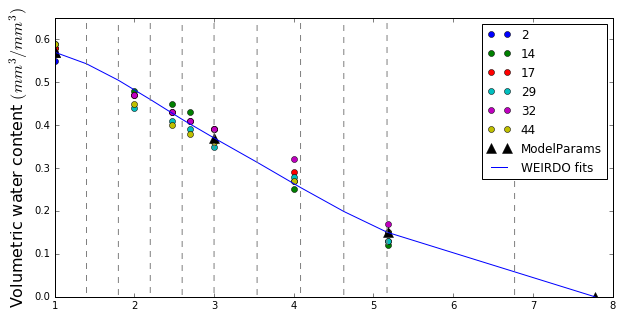

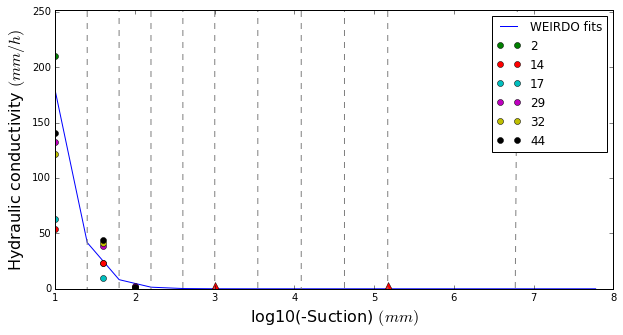

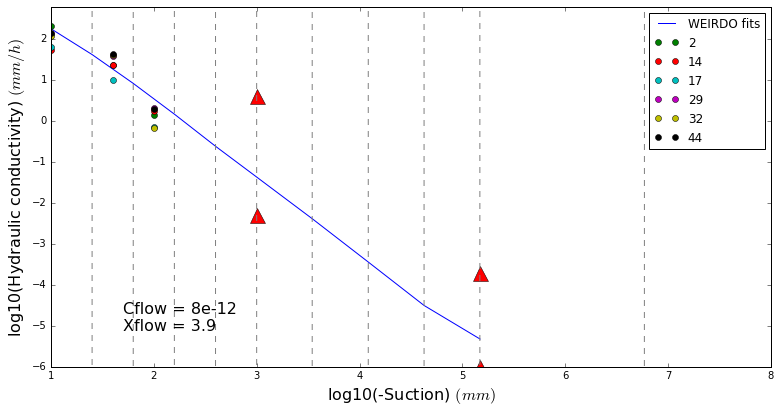

In [74]:
FitSAT = 0.57
FitDUL = 0.37
FitLL = 0.15
psibub = -10
Cflow = 8e-12
Xflow = 3.9

MRP = [10,100,300,500,1000,10000,150000]
kP = [10,40,100]
MRD = Baxters.ix['0-7.5',Baxters.columns.isin(['VWCSat','VWC1','VWC3','VWC5','VWC10','VWC100','VWC1500'])]
kD = Baxters.ix['0-7.5',Baxters.columns.isin(['k10ms','k40ms','k100ms'])]*3.6e6
FitArryK(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,MRP,kP,MRD,kD)

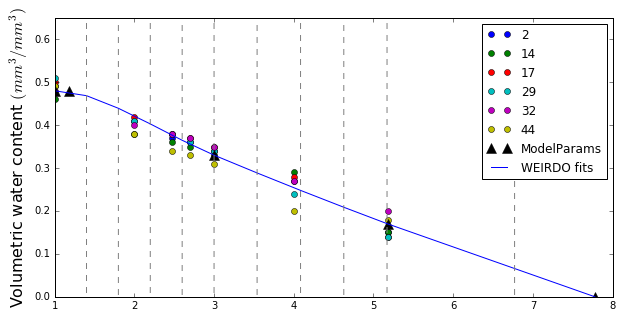

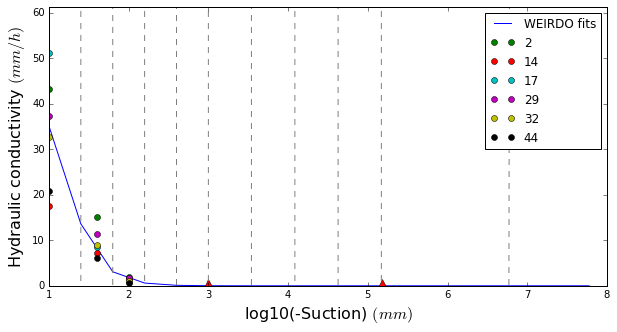

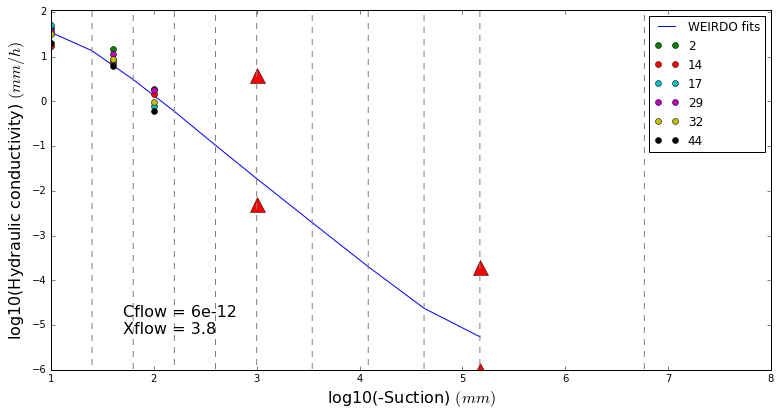

In [75]:
FitSAT = 0.48
FitDUL = 0.33
FitLL = 0.17
psibub = -15
Cflow = 6e-12
Xflow = 3.8

MRP = [10,100,300,500,1000,10000,150000]
kP = [10,40,100]
MRD = Baxters.ix['7.5-15',Baxters.columns.isin(['VWCSat','VWC1','VWC3','VWC5','VWC10','VWC100','VWC1500'])]
kD = Baxters.ix['7.5-15',Baxters.columns.isin(['k10ms','k40ms','k100ms'])]*3.6e6
FitArryK(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,MRP,kP,MRD,kD)

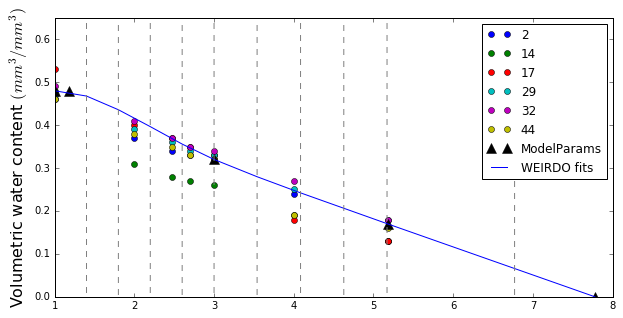

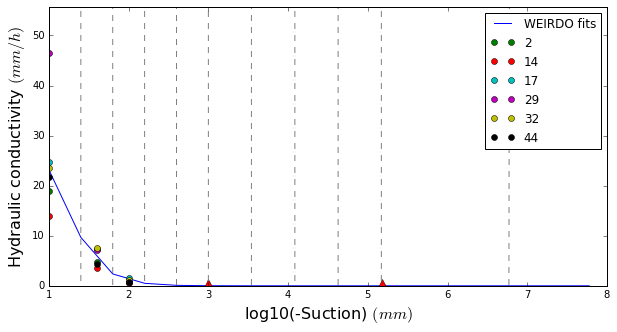

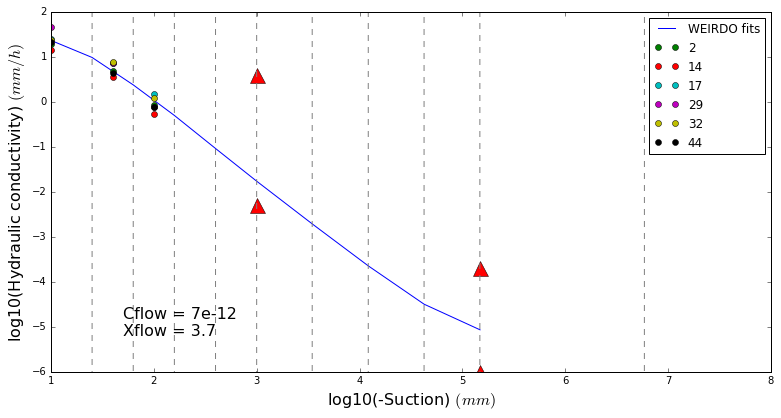

In [76]:
FitSAT = 0.48
FitDUL = 0.32
FitLL = 0.17
psibub = -15
Cflow = 7e-12
Xflow = 3.7

MRP = [10,100,300,500,1000,10000,150000]
kP = [10,40,100]
MRD = Baxters.ix['15-30',Baxters.columns.isin(['VWCSat','VWC1','VWC3','VWC5','VWC10','VWC100','VWC1500'])]
kD = Baxters.ix['15-30',Baxters.columns.isin(['k10ms','k40ms','k100ms'])]*3.6e6
FitArryK(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,MRP,kP,MRD,kD)

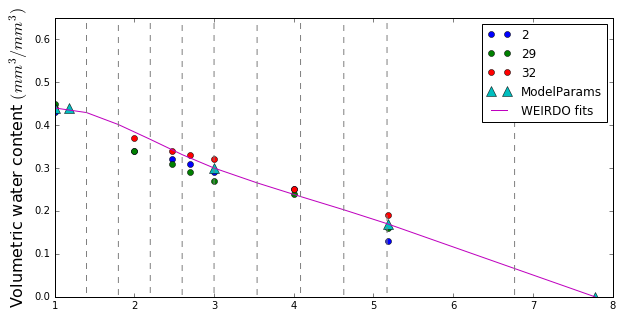

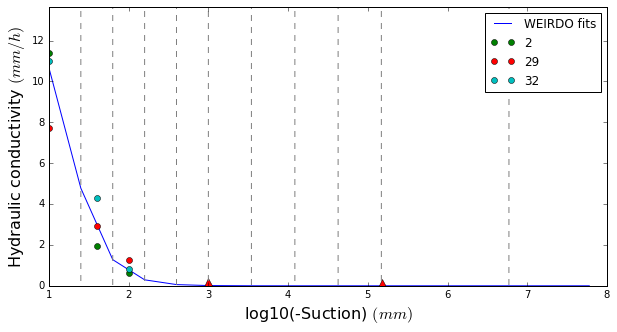

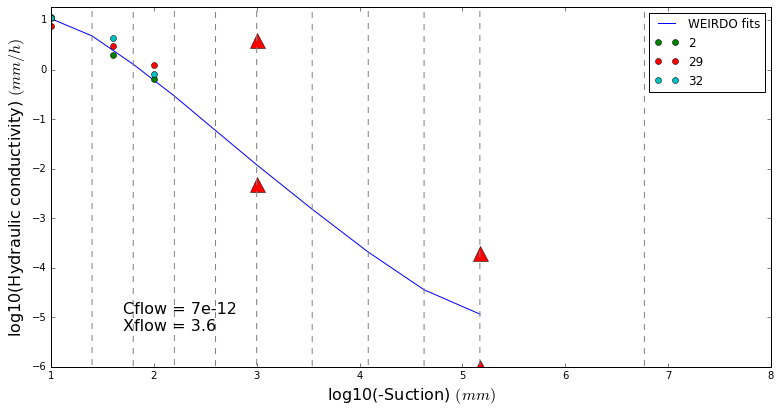

In [77]:
FitSAT = 0.44
FitDUL = 0.30
FitLL = 0.17
psibub = -15
Cflow = 7e-12
Xflow = 3.6

MRP = [10,100,300,500,1000,10000,150000]
kP = [10,40,100]
MRD = Baxters.ix['30-40',Baxters.columns.isin(['VWCSat','VWC1','VWC3','VWC5','VWC10','VWC100','VWC1500'])]
kD = Baxters.ix['30-40',Baxters.columns.isin(['k10ms','k40ms','k100ms'])]*3.6e6
FitArryK(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,MRP,kP,MRD,kD)

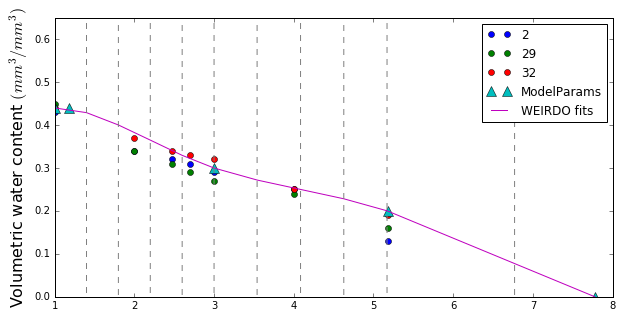

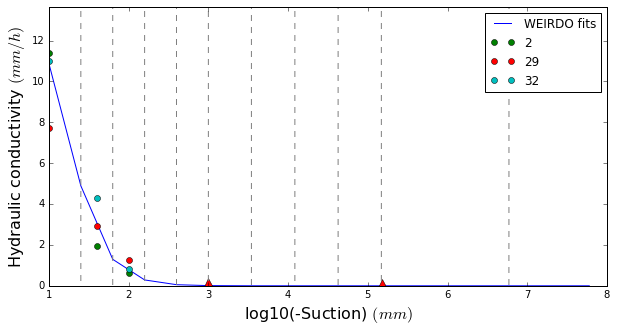

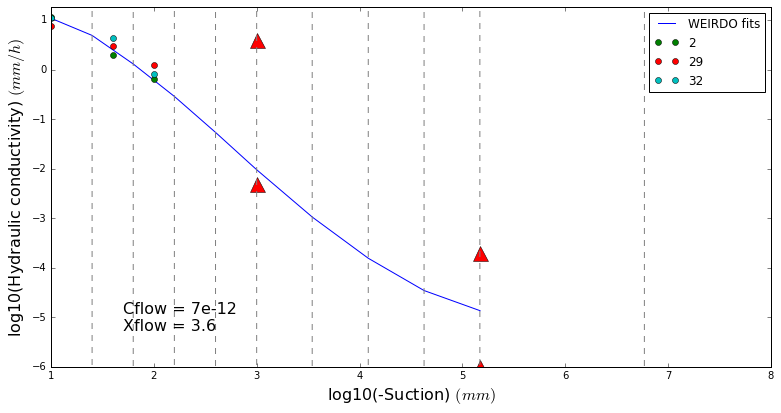

In [78]:
FitSAT = 0.44
FitDUL = 0.3
FitLL = 0.2
psibub = -15
Cflow = 7e-12
Xflow = 3.6

MRP = [10,100,300,500,1000,10000,150000]
kP = [10,40,100]
MRD = Baxters.ix['30-40',Baxters.columns.isin(['VWCSat','VWC1','VWC3','VWC5','VWC10','VWC100','VWC1500'])]
kD = Baxters.ix['30-40',Baxters.columns.isin(['k10ms','k40ms','k100ms'])]*3.6e6
#WEIRDOFunctions.ConductivityFrame(BoundPSI,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
FitArryK(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,MRP,kP,MRD,kD)

# Bring in Data for Templeton silt loams

In [79]:
CantySoils = pd.read_excel('.\Data\CantySoilData.xlsx',skiprows=2)

In [80]:
Templeton = CantySoils.ix[CantySoils.Series=='Te']

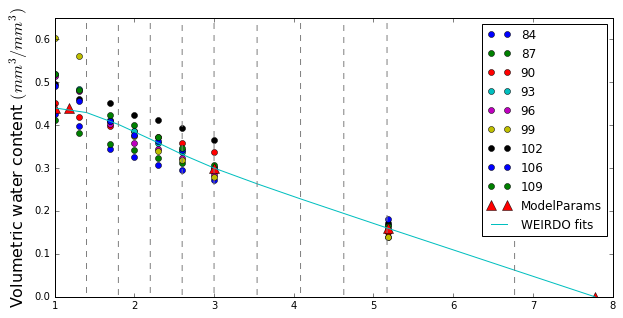

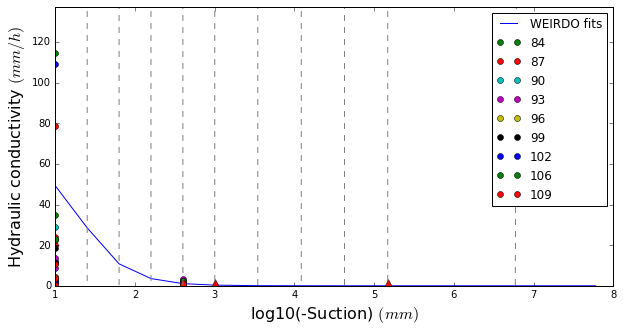

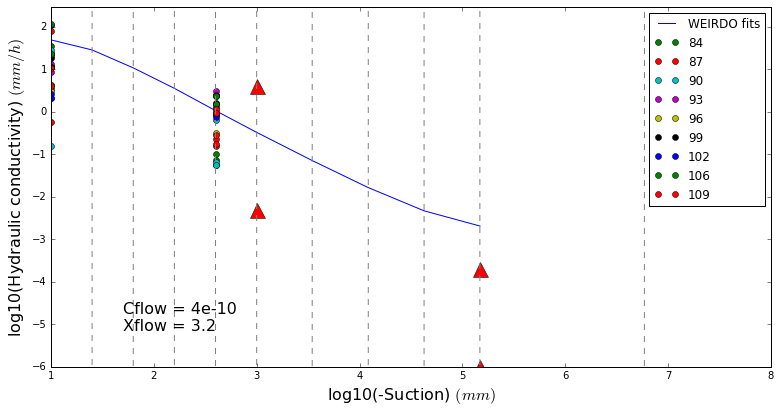

In [81]:
#Templeton Topsoils

FitSAT = 0.44
FitDUL = 0.3
FitLL = 0.16
psibub = -15
Cflow = 4e-10
Xflow = 3.2

MRP = [50,100,200,400,1000,150000,10,20]
kP = [10,10,10,400,400,400]
MRD = Templeton.ix[Templeton.FH.isin(['tLFs','tLFf','tLw']),Templeton.columns.isin(['VWSat','VW5','VW10','VW20','VW40','VW100','VW1500','Total P'])]
kD = Templeton.ix[Templeton.FH.isin(['tLFs','tLFf','tLw']),Templeton.columns.isin(['Ksat','Ksat.1','Ksat.2','K-40','K-40.1','K-40.2'])]
#WEIRDOFunctions.ConductivityFrame(BoundPSI,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
FitArryK(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,MRP,kP,MRD,kD)

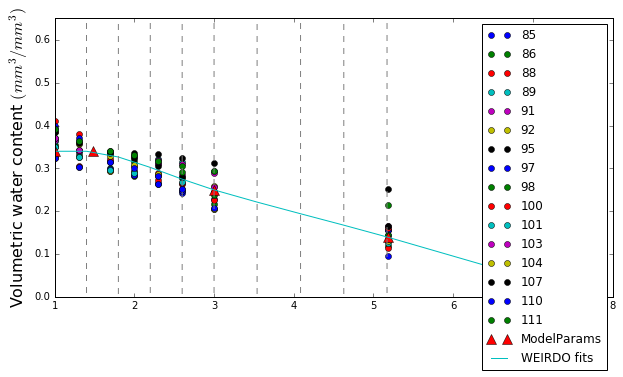

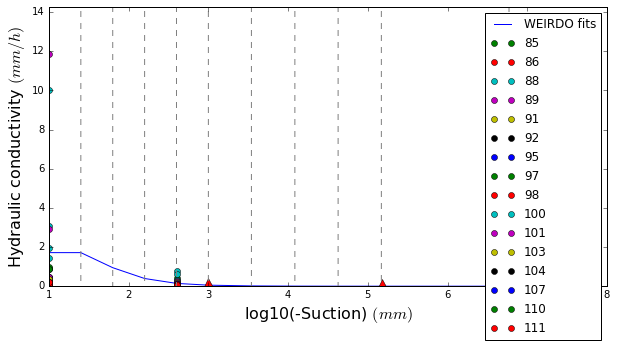

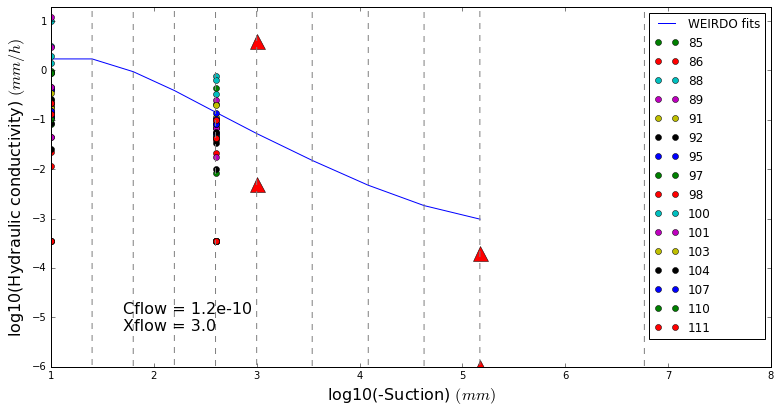

In [82]:
#Templeton silty Subsoils

FitSAT = 0.34
FitDUL = 0.25
FitLL = 0.14
psibub = -30
Cflow = 1.2e-10
Xflow = 3.

MRP = [50,100,200,400,1000,150000,10,20]
kP = [10,10,10,400,400,400]
Fhs = ['LCf','LCs']
MRD = Templeton.ix[Templeton.FH.isin(Fhs),Templeton.columns.isin(['VWSat','VW5','VW10','VW20','VW40','VW100','VW1500','Total P'])]
kD = Templeton.ix[Templeton.FH.isin(Fhs),Templeton.columns.isin(['Ksat','Ksat.1','Ksat.2','K-40','K-40.1','K-40.2'])]
#WEIRDOFunctions.ConductivityFrame(BoundPSI,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
FitArryK(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,MRP,kP,MRD,kD)

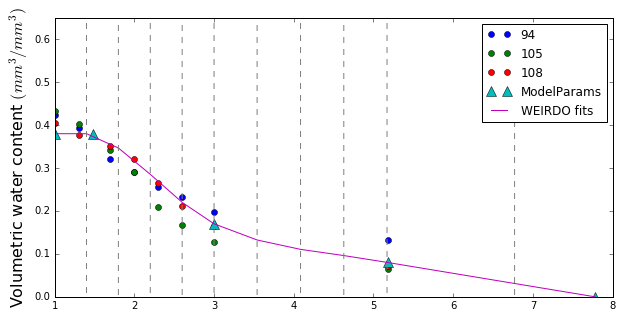

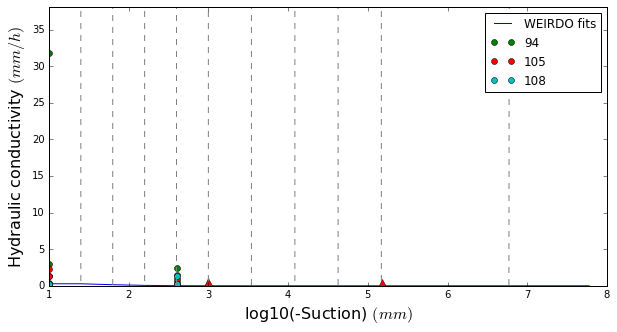

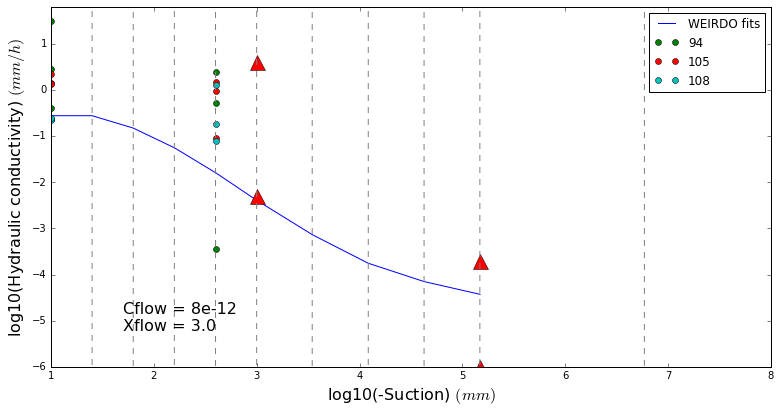

In [83]:
### Templeton Sandy Subsoils

FitSAT = 0.38
FitDUL = 0.17
FitLL = 0.08
psibub = -30
Cflow = 8e-12
Xflow = 3.

MRP = [50,100,200,400,1000,150000,10,20]
kP = [10,10,10,400,400,400]
Fhs = ['Lw','LFs']
MRD = Templeton.ix[Templeton.FH.isin(Fhs),Templeton.columns.isin(['VWSat','VW5','VW10','VW20','VW40','VW100','VW1500','Total P'])]
kD = Templeton.ix[Templeton.FH.isin(Fhs),Templeton.columns.isin(['Ksat','Ksat.1','Ksat.2','K-40','K-40.1','K-40.2'])]
#WEIRDOFunctions.ConductivityFrame(BoundPSI,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
FitArryK(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,MRP,kP,MRD,kD)

In [84]:
UNSODASoils = set(GraphData.index.tolist())
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
for soil in UNSODASoils:
    plt.plot(np.log10(GraphData.ix[soil,'preshead']),GraphData.ix[soil,'theta'],label=soil)
ax1.legend()
# ax2 = fig.add_subplot(2,1,2)
# for soil in UNSODASoils:
#     plt.plot(np.log10(GraphData.ix[soil,'preshead']),np.log10(GraphData.ix[soil,'conductivity']),label=soil)
# ax2.legend()

In [85]:
Ranks = pd.DataFrame(data=[[4672,2],[4673,3],[4671,2],[4611,2],[4612,2],[4680,1],[4681,1],[4650,4],
 [4651,4],[4620,2],[4622,2],[4592,2],[4600,2],[4660,4],[4661,4],[2362,1],
 [2362,1],[4602,2],[4670,3],[4671,3]],columns=['Soil','Rank'])

In [86]:
Ranks.size

40

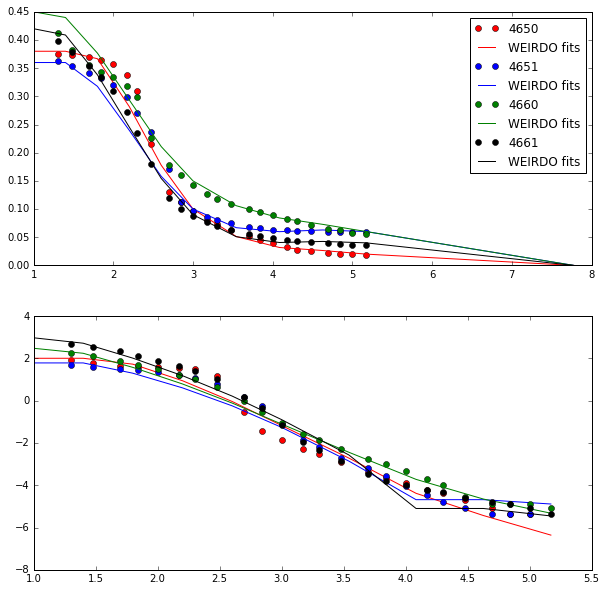

In [87]:
colours = ['r','b','g','k','y','c','m','grey','pink']
RankFilter = Ranks.ix[Ranks.Rank==4,'Soil'].values
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
colorpos = 0
for soil in RankFilter:
    soil = str(soil)
    plt.plot(np.log10(GraphData.ix[soil,'preshead']),GraphData.ix[soil,'theta'],'o',label=soil, color = colours[colorpos])
    plt.plot(np.log10(-BoundPSI),WEIRDOFunctions.ThetaCurve_mm_5pt(BoundPSI,Fits.ix[soil,'SAT'],Fits.ix[soil,'DUL'],Fits.ix[soil,'LL'],Fits.ix[soil,'psibub']),label = 'WEIRDO fits',color = colours[colorpos])
    colorpos +=1  
ax1.legend()
ax2 = fig.add_subplot(2,1,2)
colorpos = 0
for soil in RankFilter:
    soil = str(soil)
    plt.plot(np.log10(GraphData.ix[soil,'preshead']),np.log10(GraphData.ix[soil,'conductivity']),'o',label=soil,color = colours[colorpos])
    FitFrame = WEIRDOFunctions.ConductivityFrame(BoundPSI,Fits.ix[soil,'SAT'],Fits.ix[soil,'DUL'],Fits.ix[soil,'LL'],Fits.ix[soil,'psibub'],Fits.ix[soil,'Cflow'],Fits.ix[soil,'Xflow'])
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'Conductivity']),label = 'WEIRDO fits',color = colours[colorpos])
    
    colorpos +=1 

In [88]:
Fits.ix[('4680','4672','4650'),:]

SAT   DUL    LL psibub  Cflow Xflow     kSat        kFC MacroPorosity  \
4680  0.56  0.53  0.32    -20  4e-12   4.1  11.1764   0.023041          0.03   
4672  0.39  0.37  0.19   -200  6e-11   3.8  1.21417   0.173498          0.02   
4650  0.38   0.1  0.02    -50  1e-11   4.1  101.733  0.0671308          0.28   

     MatrixPorosity   Sand   Silt   Clay  
4680           0.21  0.109  0.418  0.473  
4672           0.18  0.060  0.760  0.180  
4650           0.08  0.920  0.070  0.010

In [89]:
def MakeCompGraph(soils):
    colours = ['r','b','g','k','y','c','m','grey','pink']
    yposs = [0.3,0.4,0.5]
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(2,1,1)
    colorpos = 0
    for soil in soils:
        soil = str(soil)
        plt.plot(np.log10(GraphData.ix[soil,'preshead']),GraphData.ix[soil,'theta'],'o',label=soil, color = colours[colorpos])
        plt.plot(np.log10([10,-Fits.ix[soil,'psibub'],1000,150000]),[Fits.ix[soil,'SAT'],Fits.ix[soil,'DUL']+(Fits.ix[soil,'SAT']-Fits.ix[soil,'DUL'])*1,Fits.ix[soil,'DUL'],Fits.ix[soil,'LL']],'^',markersize = 12,label = 'ModelParams',color = colours[colorpos])
        plt.plot(np.log10(-BoundPSI),WEIRDOFunctions.ThetaCurve_mm_5pt(BoundPSI,Fits.ix[soil,'SAT'],Fits.ix[soil,'DUL'],Fits.ix[soil,'LL'],Fits.ix[soil,'psibub']),'-',label = 'WEIRDO fits',color = colours[colorpos])
        tag = soil + '\n' + str(Texture.ix[int(soil),'Sand']) + ' Sa  ' + str(Texture.ix[int(soil),'Silt']) + ' Si  ' + str(Texture.ix[int(soil),'Clay']) + ' Cl'
        plt.text(5.8,yposs[colorpos],tag,color = colours[colorpos],fontsize=13)
        colorpos +=1  
    #ax1.legend()
    plt.xlim(0.8,8)
    plt.ylim(0,0.7)
    ax1.set_ylabel(r'$\theta (mm^3/mm^3)$',fontsize=16)
    plt.plot([3,3],[0,1],'--',color='k')
    plt.plot([5.16,5.16],[0,1],'--',color='k')
    plt.text(1.2,0.62,'Macro Pores',fontsize=18)
    plt.text(3.3,0.62,'Matrix Pores',fontsize=18)
    plt.text(5.5,0.62,'Micro Pores',fontsize=18)
    ax2 = fig.add_subplot(2,1,2)
    colorpos = 0
    for soil in soils:
        soil = str(soil)
        plt.plot(np.log10(GraphData.ix[soil,'preshead']),GraphData.ix[soil,'conductivity'],'o',label=soil,color = colours[colorpos])
        FitFrame = WEIRDOFunctions.ConductivityFrame(BoundPSI,Fits.ix[soil,'SAT'],Fits.ix[soil,'DUL'],Fits.ix[soil,'LL'],Fits.ix[soil,'psibub'],Fits.ix[soil,'Cflow'],Fits.ix[soil,'Xflow'])
        plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'Conductivity'],label = 'WEIRDO fits',color = colours[colorpos])
        colorpos +=1 
    plt.xlim(.8,8)
    left, bottom, width, height = [0.45, 0.17, 0.45, 0.307]
    ax2.set_xlabel(r'$log_{10}(-\Psi) ( mm)$',fontsize=16)
    ax2.set_ylabel(r'$k (mm/h)$',fontsize=16)
    plt.plot([3,3],[0,120],'--',color='k')
    #plt.plot([5.16,5.16],[0,1],'--',color='k')
    plt.text(1.2,110,'Macro Pores',fontsize=18)
    #plt.text(3.3,110,'Matrix Pores',fontsize=18)
    #plt.text(5.5,110,'Micro Pores',fontsize=18)
    
    yposs = [-6,-3,0]
    ax3 = fig.add_axes([left, bottom, width, height])
    colorpos = 0
    for soil in soils:
        soil = str(soil)
        plt.plot(np.log10(GraphData.ix[soil,'preshead']),np.log10(GraphData.ix[soil,'conductivity']),'o',label=soil,color = colours[colorpos])
        FitFrame = WEIRDOFunctions.ConductivityFrame(BoundPSI,Fits.ix[soil,'SAT'],Fits.ix[soil,'DUL'],Fits.ix[soil,'LL'],Fits.ix[soil,'psibub'],Fits.ix[soil,'Cflow'],Fits.ix[soil,'Xflow'])
        plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'Conductivity']),label = 'WEIRDO fits',color = colours[colorpos])
        tag = tag = soil + '\n' + r'$X_f=$ ' + str(Fits.ix[soil,'Xflow']) +'\n'+ r'$C_f=$' + str(Fits.ix[soil,'Cflow'])
        plt.text(5.8,yposs[colorpos],tag,color = colours[colorpos],fontsize=13)
        colorpos +=1 
    plt.xlim(.8,7.9)
    ax3.set_ylabel(r'$log_{10} (k) (mm/h)$',fontsize=12)
    plt.plot([3,3],[-100,3],'--',color='k')
    plt.plot([5.16,5.16],[-100,3],'--',color='k')
    plt.text(1.,2.5,'Macro Pores',fontsize=14)
    plt.text(3.2,2.5,'Matrix Pores',fontsize=14)
    plt.text(5.4,2.5,'Micro Pores',fontsize=14)
    plt.ylim(-7,3)

In [90]:
soils = ['4650','4602','4671'] # ['4680','4672','4650']
MakeCompGraph(soils)

In [91]:
Fits.ix[Fits.index.isin(soils)]

SAT   DUL    LL psibub  Cflow Xflow       kSat         kFC  \
4602  0.45   0.4  0.24   -200  9e-12     3  0.0263936  0.00549045   
4650  0.38   0.1  0.02    -50  1e-11   4.1    101.733   0.0671308   
4671  0.42  0.37  0.08   -100  9e-11   3.5    2.74617     0.24608   

     MacroPorosity MatrixPorosity  Sand  Silt  Clay  
4602          0.05           0.16  0.37  0.39  0.24  
4650          0.28           0.08  0.92  0.07  0.01  
4671          0.05           0.29  0.03  0.88  0.09

In [92]:
Texture.ix[[int(soils[x])for x in [0,1,2]]]

Sand  Silt  Clay
code                  
4650  0.92  0.07  0.01
4602  0.37  0.39  0.24
4671  0.03  0.88  0.09

In [93]:
SizeDistribution.ix[4602]

particle_size  particle_fraction
code                                  
4602            2.0               0.24
4602           60.0               0.63
4602          200.0               0.84
4602          600.0               0.96
4602         2000.0               1.00

In [94]:
Fits.Cflow.max()

1e-10

In [95]:
#Function to fit hudraulic conductivity components and graph results.
def FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0):
    GreaterThan0 = GraphData.ix[Set,'preshead']>0
    LessThan150000 = GraphData.ix[Set,'preshead']<150000
    NonExtremities = GreaterThan0 & LessThan150000
    
    Obs_x = GraphData.ix[Set,'preshead'][NonExtremities].values
    Obs_y = np.log10(GraphData.ix[Set,'conductivity'][NonExtremities].values)

    bounds = (lower, upper)
    res = curve_fit(Condfun, Obs_x, Obs_y, bounds=bounds, p0 = p0, method ='trf', loss = 'soft_l1',verbose = 1)

    Cflow = res[0][0]
    Xflow = res[0][1]

    FitFrame = WEIRDOFunctions.ConductivityFrame(BoundPSI,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

    Fits.ix[Set,'SAT'] = FitSAT
    Fits.ix[Set,'DUL'] = FitDUL
    Fits.ix[Set,'LL'] = FitLL
    Fits.ix[Set,'psibub'] = psibub
    Fits.ix[Set,'Cflow'] = Cflow
    Fits.ix[Set,'Xflow'] = Xflow
    Fits.ix[Set,'kSat'] = FitFrame.ix[0,'Conductivity']
    Fits.ix[Set,'kFC'] = FitFrame.ix[5,'Conductivity']

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
    plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*1,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
    plt.plot(np.log10(-BoundPSI),WEIRDOFunctions.ThetaCurve_mm_5pt(BoundPSI,FitSAT,FitDUL,FitLL,psibub),label = 'WEIRDO fits')
    plt.plot([1],PropsDataFull.ix[Set,'EstPorosity'],'^',markersize = 10,label = 'Porosity')
    plt.ylim(0,0.65)
    plt.text(1.5,.58,'Soil ID ' +Set,fontsize=18)
    plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
    plt.legend()

    ymax = GraphData.ix[Set,'conductivity'][GraphData.ix[Set,'preshead']>0].max()*2
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'Conductivity'],label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
    plt.text(4,ymax*.8,'KSat = ' + '%.4g' % FitFrame.ix[0,'Conductivity'] + '\nKFC = ' + '%.4g' % FitFrame.ix[5,'Conductivity'],fontsize=16)
    plt.text(4,ymax*.65, 'KSatObs = ' + '%.4g' % PropsDataFull.ix[Set,'k_sat'],fontsize = 16)
    plt.ylim(0,ymax)
    plt.legend()

    CoeffPos =  np.log10(FitFrame.ix[:,'Conductivity'].max())*.1
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_axes([0,0,1,1])
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'Conductivity']),label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
    intLog10Cond = interpCond(GraphData.ix[Set,'preshead'][NonExtremities].values,FitFrame.ix[:,'PsiUpper'],FitFrame.ix[:,'Conductivity'])
    plt.plot(np.log10(GraphData.ix[Set,'preshead'][NonExtremities].values),intLog10Cond,'o',label = 'InterpFitPoints')
    plt.text(0.1,0.1,'Cflow = ' + '%.4g' % Cflow + '\nXflow = ' + str(Xflow)[0:5], fontsize = 16, transform=ax.transAxes)
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
    plt.xlim(1,8)
    
    plt.legend()

In [96]:
8e-12

8e-12

In [97]:
.08 * 1e-10

8e-12